In [1]:
import numpy as np
import scipy.signal as signal
import netCDF4 as nc
import matplotlib.pyplot as plt
import pywt  # PyWavelets for wavelet transforms

ModuleNotFoundError: No module named 'scipy'

In [5]:
# Load the NetCDF file
data_path = "29AP2022SHT1_r5_BAPBS_p.nc"  # Adjust the filename as per your download
dataset = nc.Dataset(data_path, 'r')

In [6]:
# Explore variables
print("Variables in the dataset:", dataset.variables.keys())

Variables in the dataset: dict_keys(['Headers', 'Procparams', 'SpecProcparams', 'RawI.R.1.C.1.B.1', 'RawQ.R.1.C.1.B.1', 'SpecPSD.R.1.C.1.B.1', 'TracePeak.R.1.C.1.B.1', 'TraceUSPeak.R.1.C.1.B.1', 'TraceSP.R.1.C.1.B.1', 'MMTMT.R.1.C.1.B.1', 'MMTMain.R.1.C.1.B.1', 'MMTEM.R.1.C.1.B.1', 'RawI.R.1.C.1.B.2', 'RawQ.R.1.C.1.B.2', 'SpecPSD.R.1.C.1.B.2', 'TracePeak.R.1.C.1.B.2', 'TraceUSPeak.R.1.C.1.B.2', 'TraceSP.R.1.C.1.B.2', 'MMTMT.R.1.C.1.B.2', 'MMTMain.R.1.C.1.B.2', 'MMTEM.R.1.C.1.B.2', 'RawI.R.1.C.1.B.3', 'RawQ.R.1.C.1.B.3', 'SpecPSD.R.1.C.1.B.3', 'TracePeak.R.1.C.1.B.3', 'TraceUSPeak.R.1.C.1.B.3', 'TraceSP.R.1.C.1.B.3', 'MMTMT.R.1.C.1.B.3', 'MMTMain.R.1.C.1.B.3', 'MMTEM.R.1.C.1.B.3', 'RawI.R.1.C.1.B.4', 'RawQ.R.1.C.1.B.4', 'SpecPSD.R.1.C.1.B.4', 'TracePeak.R.1.C.1.B.4', 'TraceUSPeak.R.1.C.1.B.4', 'TraceSP.R.1.C.1.B.4', 'MMTMT.R.1.C.1.B.4', 'MMTMain.R.1.C.1.B.4', 'MMTEM.R.1.C.1.B.4', 'RawI.R.1.C.1.B.5', 'RawQ.R.1.C.1.B.5', 'SpecPSD.R.1.C.1.B.5', 'TracePeak.R.1.C.1.B.5', 'TraceUSPeak.R.1.C.1

In [7]:
# Parameters from the paper and your data structure
range_bins = 180  # Number of range bins
cycles = 17       # Number of cycles (C.1 to C.17)
beams = 5         # Number of beams (B.1 to B.5)
nfft = 256        # Frequency samples per frame
inci = 5          # Number of incoherent integrations

# Initialize an array to hold IQ data for all cycles, beams, and INCI
# Shape: (cycles, beams, inci, range_bins, nfft)
iq_data = np.zeros((cycles, beams, inci, range_bins, nfft), dtype=complex)

# Extract and combine RawI and RawQ for each cycle and beam
for c in range(1, cycles + 1):  # Cycles 1 to 17
    for b in range(1, beams + 1):  # Beams 1 to 5
        # Variable names follow the pattern 'RawI.R.1.C.{c}.B.{b}' and 'RawQ.R.1.C.{c}.B.{b}'
        raw_i_key = f'RawI.R.1.C.{c}.B.{b}'
        raw_q_key = f'RawQ.R.1.C.{c}.B.{b}'
        
        # Check if the keys exist in the dataset
        if raw_i_key in dataset.variables and raw_q_key in dataset.variables:
            raw_i = dataset.variables[raw_i_key][:]  # In-phase component, shape (5, 180, 256)
            raw_q = dataset.variables[raw_q_key][:]  # Quadrature component, shape (5, 180, 256)
            # Combine into complex IQ data: IQ = I + j*Q
            iq_data[c-1, b-1, :, :, :] = raw_i + 1j * raw_q
        else:
            print(f"Warning: Variables {raw_i_key} or {raw_q_key} not found.")

# Print the shape of the combined IQ data
print("IQ Data Shape:", iq_data.shape)

# Close the dataset
dataset.close()

IQ Data Shape: (17, 5, 5, 180, 256)


In [8]:
# Parameters from the paper
nfft = 256  # Original frequency samples per frame
nci = 5     # Number of coherent integrations (not directly used here)
inci = 5    # Number of incoherent integrations
cycles = 17 # Number of cycles
beams = 5   # Number of beams (E, W, Z, N, S)
range_bins = 180

# Select data for one cycle and one beam (e.g., cycle 1, beam 1)
cycle_idx = 0  # First cycle (C.1)
beam_idx = 0   # First beam (B.1)
iq_frames = iq_data[cycle_idx, beam_idx, :, :, :]  # Shape: (5, 180, 256)

# Collate 1280 samples (256 nFFT * 5 INCI) across the 5 incoherent integrations
collated_data = np.zeros((range_bins, nfft * inci), dtype=complex)
for rb in range(range_bins):
    # Concatenate the 5 INCI frames for this range bin
    collated_data[rb, :] = np.concatenate([iq_frames[i, rb, :] for i in range(inci)])

# Split into 12 segments of 512 samples with zero-padding
segments_per_bin = 12
segment_length = 512
segmented_data = np.zeros((range_bins, segments_per_bin, segment_length), dtype=complex)

for rb in range(range_bins):
    for seg in range(segments_per_bin):
        start = seg * (nfft * inci // segments_per_bin)
        end = start + segment_length
        segment = collated_data[rb, start:end]
        if len(segment) < segment_length:
            segment = np.pad(segment, (0, segment_length - len(segment)), mode='constant')
        segmented_data[rb, seg, :] = segment

# Apply Kaiser window
kaiser_window = signal.windows.kaiser(segment_length, beta=5.85)
segmented_data = segmented_data * kaiser_window[None, None, :]

print("Segmented Data Shape:", segmented_data.shape)

Segmented Data Shape: (180, 12, 512)


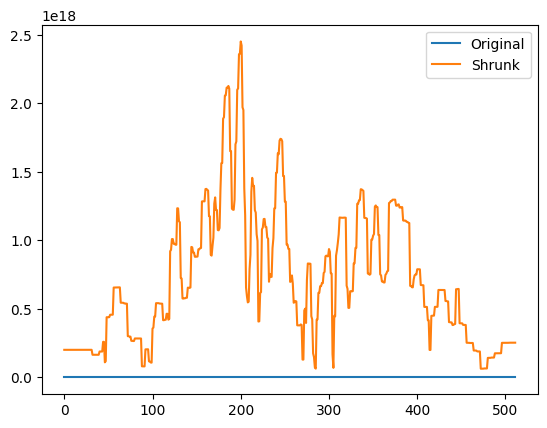

In [11]:
def mst_abs(Ssig, coarsest=3, finestlev=8):
    """
    Adaptive-Bayesian Shrinkage for one segment of IQ data.
    Ssig: Input segment (512 samples)
    """
    # Step 2.1: Forward Wavelet Transform
    wavelet = 'haar'  # Gaussian QMF approximated with Haar for simplicity
    coeffs = pywt.wavedec(Ssig, wavelet, level=finestlev, mode='periodization')
    datawd, coeff_slices = pywt.coeffs_to_array(coeffs)  # Unpack both outputs
    
    # Step 2.2: Compute prior parameters
    # Mean structure (μ)
    niz = datawd[2**finestlev:2**(finestlev+1)]
    nizo = np.sort(np.abs(niz))
    mm = len(nizo)
    Q1 = nizo[int(mm/4)] if mm > 0 else 0
    Q3 = nizo[int(3*mm/4)] if mm > 0 else 0
    Pseudos = abs(Q1 - Q3) / 1.5
    mu = 1 / Pseudos**2 if Pseudos != 0 else 1e-10
    
    # Scale of spread (τ)
    sigma_d2 = np.var(Ssig)
    tau = np.sqrt(max(sigma_d2 - (1/mu), 0))
    
    # Step 2.3: Iterative shrinkage across levels
    for i in range(finestlev, coarsest-1, -1):
        # Weight of point mass (ϵ)
        epsilon = 1 - (1 / (i - coarsest + 1)**1.5)
        
        # Compute densities and shrinkage
        d = datawd[2**i:2**(i+1)] if i < finestlev else datawd[2**i:]
        if len(d) == 0:
            continue
        
        # Marginal likelihood
        de = 0.5 * np.sqrt(2*mu) * np.exp(-np.sqrt(2*mu) * np.abs(d))
        
        # Predictive distribution
        m = (tau * np.exp(-np.abs(d)/tau) - (1/np.sqrt(2*mu)) * np.exp(-np.sqrt(2*mu)*np.abs(d))) / (2*tau**2 - (1/mu))
        
        # Marginal distribution
        m_star = epsilon * de + (1 - epsilon) * m
        
        # Bayes rule shrinkage
        delta = (tau * (tau**2 - 1/(2*mu)) * d * np.exp(-np.abs(d)/tau) + 
                 tau**2 * (np.exp(-np.abs(d)*np.sqrt(2*mu)) - np.exp(-np.abs(d)/tau))) / mu
        delta /= ((tau**2 - 1/(2*mu)) * (tau * np.exp(-np.abs(d)/tau) - (1/np.sqrt(2*mu)) * np.exp(-np.abs(d)*np.sqrt(2*mu))))
        delta_star = ((1 - epsilon) * m * delta) / ((1 - epsilon) * m + epsilon * de)
        
        # Update coefficients
        if i < finestlev:
            datawd[2**i:2**(i+1)] = delta_star
        else:
            datawd[2**i:] = delta_star
    
    # Step 2.4: Inverse Wavelet Transform
    try:
        coeffs_updated = pywt.array_to_coeffs(datawd, coeff_slices, output_format='wavedec')
        YSig = pywt.waverec(coeffs_updated, wavelet, mode='periodization')
    except Exception as e:
        print(f"Error in inverse transform: {e}")
        raise
    
    return YSig[:len(Ssig)]  # Ensure output matches input length

# Test on one segment
test_segment = segmented_data[0, 0, :]
YSig = mst_abs(test_segment)
plt.plot(np.abs(test_segment), label='Original')
plt.plot(np.abs(YSig), label='Shrunk')
plt.legend()
plt.show()

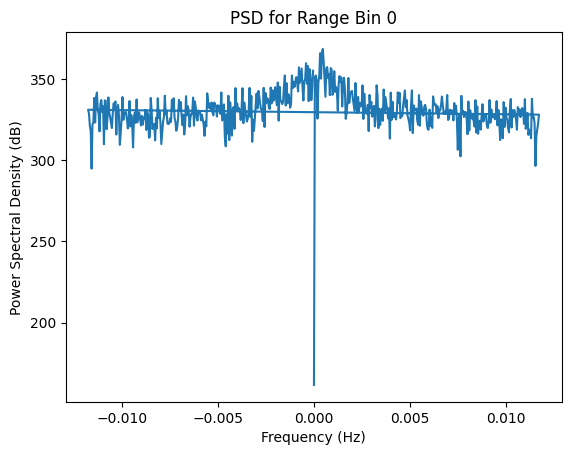

In [12]:
# Process all segments for one range bin (e.g., rb=0)
rb = 0
YSig_all = np.zeros((segments_per_bin, segment_length), dtype=complex)
for seg in range(segments_per_bin):
    YSig_all[seg, :] = mst_abs(segmented_data[rb, seg, :])

# Incoherent integration
YSig_integrated = np.mean(YSig_all, axis=0)

# Compute PSD
psd = np.abs(np.fft.fft(YSig_integrated))**2 / segment_length
freqs = np.fft.fftfreq(segment_length, d=1/0.0235)  # Frequency resolution from paper

plt.plot(freqs, 10*np.log10(psd))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title(f'PSD for Range Bin {rb}')
plt.show()

In [13]:
print("Segmented Data Shape:", segmented_data.shape)
print("Test Segment Shape:", test_segment.shape)
print("Test Segment Min/Max (Magnitude):", np.abs(test_segment).min(), np.abs(test_segment).max())
print("Test Segment Real Min/Max:", test_segment.real.min(), test_segment.real.max())
print("Test Segment Imag Min/Max:", test_segment.imag.min(), test_segment.imag.max())

Segmented Data Shape: (180, 12, 512)
Test Segment Shape: (512,)
Test Segment Min/Max (Magnitude): 8624.591499060483 34446974.59536673
Test Segment Real Min/Max: -642238.7403862327 27733018.487472925
Test Segment Imag Min/Max: -549389.7231989057 27779312.9894914


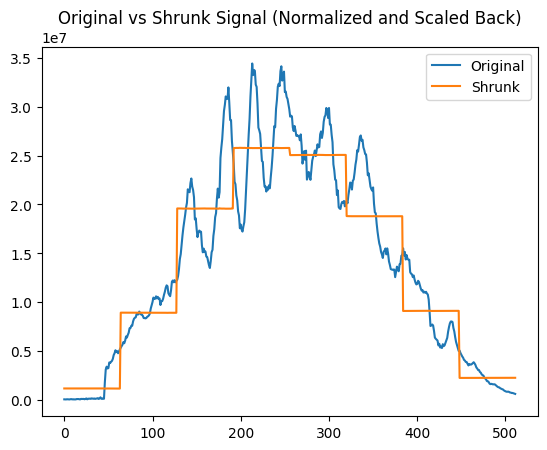

Test Segment Min/Max (Magnitude): 8624.591499060483 34446974.59536673
Normalized Test Segment Min/Max (Magnitude): 0.0002503729747058985 1.0
Shrunk Signal Min/Max (Magnitude): 1123254.3777249628 25802170.619869437


In [15]:
def mst_abs(Ssig, coarsest=3, finestlev=8):
    """
    Adaptive-Bayesian Shrinkage for one segment of complex IQ data.
    Ssig: Input complex segment (normalized to reasonable range)
    """
    # Separate real and imaginary parts
    real_part = Ssig.real
    imag_part = Ssig.imag
    
    # Step 2.1: Forward Wavelet Transform for real and imaginary parts
    wavelet = 'haar'  # Gaussian QMF approximated with Haar for simplicity
    coeffs_real = pywt.wavedec(real_part, wavelet, level=finestlev, mode='periodization')
    coeffs_imag = pywt.wavedec(imag_part, wavelet, level=finestlev, mode='periodization')
    
    # Flatten coefficients for real and imaginary parts
    datawd_real, coeff_slices = pywt.coeffs_to_array(coeffs_real)
    datawd_imag, _ = pywt.coeffs_to_array(coeffs_imag)  # Reuse coeff_slices
    
    # Step 2.2: Compute prior parameters (combine real and imaginary for statistics)
    # Use magnitude for robustness
    datawd_mag = np.sqrt(datawd_real**2 + datawd_imag**2)
    niz = datawd_mag[2**finestlev:2**(finestlev+1)]
    nizo = np.sort(np.abs(niz))
    mm = len(nizo)
    Q1 = nizo[int(mm/4)] if mm > 0 else 0
    Q3 = nizo[int(3*mm/4)] if mm > 0 else 0
    Pseudos = abs(Q1 - Q3) / 1.5
    mu = 1 / Pseudos**2 if Pseudos != 0 else 1e-10
    
    # Scale of spread (τ) based on input signal magnitude
    sigma_d2 = np.var(np.abs(Ssig))
    tau = np.sqrt(max(sigma_d2 - (1/mu), 0))
    
    # Step 2.3: Iterative shrinkage across levels (for both real and imaginary)
    for i in range(finestlev, coarsest-1, -1):
        # Weight of point mass (ϵ)
        epsilon = 1 - (1 / (i - coarsest + 1)**1.5)
        
        # Real part
        d_real = datawd_real[2**i:2**(i+1)] if i < finestlev else datawd_real[2**i:]
        if len(d_real) == 0:
            continue
        
        # Imaginary part
        d_imag = datawd_imag[2**i:2**(i+1)] if i < finestlev else datawd_imag[2**i:]
        
        # Compute densities and shrinkage (using magnitude for stability)
        d_mag = np.sqrt(d_real**2 + d_imag**2)
        de = 0.5 * np.sqrt(2*mu) * np.exp(-np.sqrt(2*mu) * np.abs(d_mag))
        m = (tau * np.exp(-np.abs(d_mag)/tau) - (1/np.sqrt(2*mu)) * np.exp(-np.sqrt(2*mu)*np.abs(d_mag))) / (2*tau**2 - (1/mu))
        m_star = epsilon * de + (1 - epsilon) * m
        
        # Bayes rule shrinkage (apply to real and imaginary proportionally)
        delta_mag = (tau * (tau**2 - 1/(2*mu)) * d_mag * np.exp(-np.abs(d_mag)/tau) + 
                     tau**2 * (np.exp(-np.abs(d_mag)*np.sqrt(2*mu)) - np.exp(-np.abs(d_mag)/tau))) / mu
        delta_mag /= ((tau**2 - 1/(2*mu)) * (tau * np.exp(-np.abs(d_mag)/tau) - (1/np.sqrt(2*mu)) * np.exp(-np.abs(d_mag)*np.sqrt(2*mu))))
        delta_star = ((1 - epsilon) * m * delta_mag) / ((1 - epsilon) * m + epsilon * de)
        
        # Update real and imaginary parts (scale by original magnitude direction)
        if len(d_real) > 0:
            direction = d_real + 1j * d_imag
            direction_mag = np.abs(direction)
            direction_normalized = direction / (direction_mag + 1e-10)  # Avoid division by zero
            delta_real = delta_star * direction_normalized.real
            delta_imag = delta_star * direction_normalized.imag
            
            if i < finestlev:
                datawd_real[2**i:2**(i+1)] = delta_real
                datawd_imag[2**i:2**(i+1)] = delta_imag
            else:
                datawd_real[2**i:] = delta_real
                datawd_imag[2**i:] = delta_imag
    
    # Step 2.4: Inverse Wavelet Transform for real and imaginary parts
    coeffs_updated_real = pywt.array_to_coeffs(datawd_real, coeff_slices, output_format='wavedec')
    coeffs_updated_imag = pywt.array_to_coeffs(datawd_imag, coeff_slices, output_format='wavedec')
    YSig_real = pywt.waverec(coeffs_updated_real, wavelet, mode='periodization')
    YSig_imag = pywt.waverec(coeffs_updated_imag, wavelet, mode='periodization')
    
    # Combine real and imaginary parts
    YSig = YSig_real + 1j * YSig_imag
    
    return YSig[:len(Ssig)]  # Ensure output matches input length

# Test on one segment with normalization
test_segment = segmented_data[0, 0, :]
max_magnitude = np.abs(test_segment).max()
test_segment_normalized = test_segment / (max_magnitude + 1e-10)  # Normalize to max magnitude of 1

YSig_normalized = mst_abs(test_segment_normalized)
YSig_scaled = YSig_normalized * max_magnitude  # Scale back to original magnitude range

plt.plot(np.abs(test_segment), label='Original')
plt.plot(np.abs(YSig_scaled), label='Shrunk')
plt.legend()
plt.title('Original vs Shrunk Signal (Normalized and Scaled Back)')
plt.show()

# Debug prints for TABS calculations
print("Test Segment Min/Max (Magnitude):", np.abs(test_segment).min(), np.abs(test_segment).max())
print("Normalized Test Segment Min/Max (Magnitude):", np.abs(test_segment_normalized).min(), np.abs(test_segment_normalized).max())
print("Shrunk Signal Min/Max (Magnitude):", np.abs(YSig_scaled).min(), np.abs(YSig_scaled).max())

mu: 6694.0897214253355
tau: 0.28984624797276654
Level 8 - epsilon: 0.9319586182560229, delta_mag min/max: -0.0005066314301325739, -1.9949178753940416e-05, delta_star min/max: -0.0004440734871521703, -4.377571744229148e-08
Level 7 - epsilon: 0.9105572809000084, delta_mag min/max: -0.0005066290172756174, -1.6470517694282384e-05, delta_star min/max: -0.0004987890115536864, -4.8251669028501816e-08
Level 6 - epsilon: 0.875, delta_mag min/max: -0.000506630561573016, -3.087792314845027e-05, delta_star min/max: -0.0004993153965654844, -1.352803144234249e-07
Level 5 - epsilon: 0.8075499102701247, delta_mag min/max: -0.0005060053497266591, -1.4799530916050459e-05, delta_star min/max: -0.0004999883509261995, -1.0440202626182474e-07
Level 4 - epsilon: 0.6464466094067263, delta_mag min/max: -0.000506627631299441, -5.341410590031975e-05, delta_star min/max: -0.000500205714419554, -9.274506509996404e-07
Level 3 - epsilon: 0.0, delta_mag min/max: -0.0004934913291615219, -0.0003542518006625283, delta_s

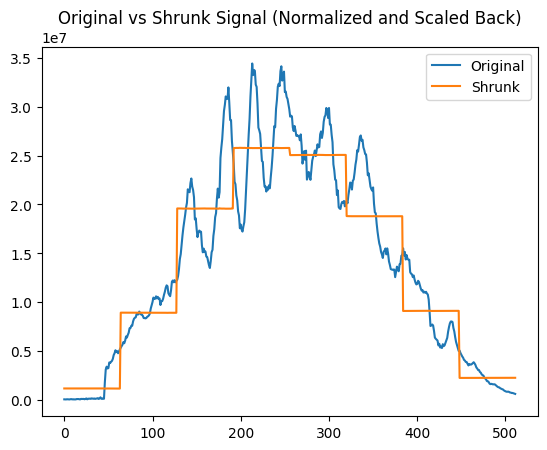

Test Segment Min/Max (Magnitude): 8624.591499060483 34446974.59536673
Normalized Test Segment Min/Max (Magnitude): 0.0002503729747058985 1.0
Shrunk Signal Min/Max (Magnitude): 1123254.3777249628 25802170.619869437


In [16]:
def mst_abs(Ssig, coarsest=3, finestlev=8):
    """
    Adaptive-Bayesian Shrinkage for one segment of complex IQ data.
    Ssig: Input complex segment (normalized to reasonable range)
    """
    # Separate real and imaginary parts
    real_part = Ssig.real
    imag_part = Ssig.imag
    
    # Step 2.1: Forward Wavelet Transform for real and imaginary parts
    wavelet = 'haar'  # Gaussian QMF approximated with Haar for simplicity
    coeffs_real = pywt.wavedec(real_part, wavelet, level=finestlev, mode='periodization')
    coeffs_imag = pywt.wavedec(imag_part, wavelet, level=finestlev, mode='periodization')
    
    # Flatten coefficients for real and imaginary parts
    datawd_real, coeff_slices = pywt.coeffs_to_array(coeffs_real)
    datawd_imag, _ = pywt.coeffs_to_array(coeffs_imag)  # Reuse coeff_slices
    
    # Step 2.2: Compute prior parameters (combine real and imaginary for statistics)
    # Use magnitude for robustness
    datawd_mag = np.sqrt(datawd_real**2 + datawd_imag**2)
    niz = datawd_mag[2**finestlev:2**(finestlev+1)]
    nizo = np.sort(np.abs(niz))
    mm = len(nizo)
    Q1 = nizo[int(mm/4)] if mm > 0 else 0
    Q3 = nizo[int(3*mm/4)] if mm > 0 else 0
    Pseudos = abs(Q1 - Q3) / 1.5
    mu = 1 / Pseudos**2 if Pseudos != 0 else 1e-10
    
    # Scale of spread (τ) based on input signal magnitude
    sigma_d2 = np.var(np.abs(Ssig))
    tau = np.sqrt(max(sigma_d2 - (1/mu), 0))
    
    print("mu:", mu)
    print("tau:", tau)
    
    # Step 2.3: Iterative shrinkage across levels (for both real and imaginary)
    for i in range(finestlev, coarsest-1, -1):
        # Weight of point mass (ϵ)
        epsilon = 1 - (1 / (i - coarsest + 1)**1.5)
        
        # Real part
        d_real = datawd_real[2**i:2**(i+1)] if i < finestlev else datawd_real[2**i:]
        if len(d_real) == 0:
            continue
        
        # Imaginary part
        d_imag = datawd_imag[2**i:2**(i+1)] if i < finestlev else datawd_imag[2**i:]
        
        # Compute densities and shrinkage (using magnitude for stability)
        d_mag = np.sqrt(d_real**2 + d_imag**2)
        de = 0.5 * np.sqrt(2*mu) * np.exp(-np.sqrt(2*mu) * np.abs(d_mag))
        m = (tau * np.exp(-np.abs(d_mag)/tau) - (1/np.sqrt(2*mu)) * np.exp(-np.sqrt(2*mu)*np.abs(d_mag))) / (2*tau**2 - (1/mu))
        m_star = epsilon * de + (1 - epsilon) * m
        
        # Bayes rule shrinkage (apply to real and imaginary proportionally)
        delta_mag = (tau * (tau**2 - 1/(2*mu)) * d_mag * np.exp(-np.abs(d_mag)/tau) + 
                     tau**2 * (np.exp(-np.abs(d_mag)*np.sqrt(2*mu)) - np.exp(-np.abs(d_mag)/tau))) / mu
        delta_mag /= ((tau**2 - 1/(2*mu)) * (tau * np.exp(-np.abs(d_mag)/tau) - (1/np.sqrt(2*mu)) * np.exp(-np.abs(d_mag)*np.sqrt(2*mu))))
        delta_star = ((1 - epsilon) * m * delta_mag) / ((1 - epsilon) * m + epsilon * de)
        
        print(f"Level {i} - epsilon: {epsilon}, delta_mag min/max: {delta_mag.min()}, {delta_mag.max()}, delta_star min/max: {delta_star.min()}, {delta_star.max()}")
        
        # Update real and imaginary parts (scale by original magnitude direction)
        if len(d_real) > 0:
            direction = d_real + 1j * d_imag
            direction_mag = np.abs(direction)
            direction_normalized = direction / (direction_mag + 1e-10)  # Avoid division by zero
            delta_real = delta_star * direction_normalized.real
            delta_imag = delta_star * direction_normalized.imag
            
            if i < finestlev:
                datawd_real[2**i:2**(i+1)] = delta_real
                datawd_imag[2**i:2**(i+1)] = delta_imag
            else:
                datawd_real[2**i:] = delta_real
                datawd_imag[2**i:] = delta_imag
    
    # Step 2.4: Inverse Wavelet Transform for real and imaginary parts
    coeffs_updated_real = pywt.array_to_coeffs(datawd_real, coeff_slices, output_format='wavedec')
    coeffs_updated_imag = pywt.array_to_coeffs(datawd_imag, coeff_slices, output_format='wavedec')
    YSig_real = pywt.waverec(coeffs_updated_real, wavelet, mode='periodization')
    YSig_imag = pywt.waverec(coeffs_updated_imag, wavelet, mode='periodization')
    
    # Combine real and imaginary parts
    YSig = YSig_real + 1j * YSig_imag
    
    return YSig[:len(Ssig)]  # Ensure output matches input length

# Test on one segment with normalization
test_segment = segmented_data[0, 0, :]
max_magnitude = np.abs(test_segment).max()
test_segment_normalized = test_segment / (max_magnitude + 1e-10)  # Normalize to max magnitude of 1

YSig_normalized = mst_abs(test_segment_normalized)
YSig_scaled = YSig_normalized * max_magnitude  # Scale back to original magnitude range

plt.plot(np.abs(test_segment), label='Original')
plt.plot(np.abs(YSig_scaled), label='Shrunk')
plt.legend()
plt.title('Original vs Shrunk Signal (Normalized and Scaled Back)')
plt.show()

# Debug prints for input and output
print("Test Segment Min/Max (Magnitude):", np.abs(test_segment).min(), np.abs(test_segment).max())
print("Normalized Test Segment Min/Max (Magnitude):", np.abs(test_segment_normalized).min(), np.abs(test_segment_normalized).max())
print("Shrunk Signal Min/Max (Magnitude):", np.abs(YSig_scaled).min(), np.abs(YSig_scaled).max())

mu: 6694.0897214253355
tau: 0.28984624797276654
Level 8 - epsilon: 0.8333333333333334, delta_mag min/max: 0.0, 0.0, delta_star min/max: 0.0, 0.0
Level 7 - epsilon: 0.8, delta_mag min/max: 0.0, 0.0, delta_star min/max: 0.0, 0.0
Level 6 - epsilon: 0.75, delta_mag min/max: 0.0, 0.0, delta_star min/max: 0.0, 0.0
Level 5 - epsilon: 0.6666666666666667, delta_mag min/max: 0.0, 0.0, delta_star min/max: 0.0, 0.0
Level 4 - epsilon: 0.5, delta_mag min/max: 0.0, 0.0, delta_star min/max: 0.0, 0.0
Level 3 - epsilon: 0.0, delta_mag min/max: 0.0, 0.0, delta_star min/max: 0.0, 0.0


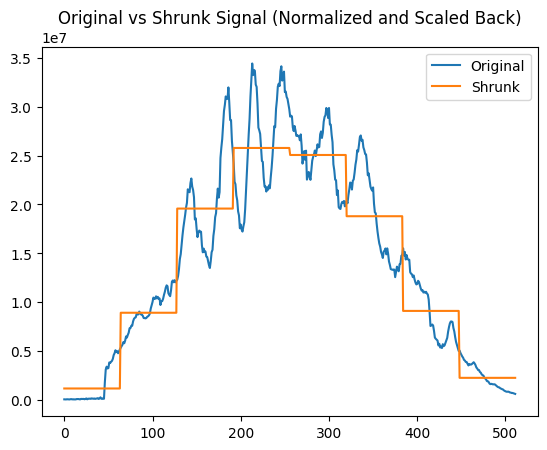

Test Segment Min/Max (Magnitude): 8624.591499060483 34446974.59536673
Normalized Test Segment Min/Max (Magnitude): 0.0002503729747058985 1.0
Shrunk Signal Min/Max (Magnitude): 1135372.9428781846 25787652.89674871


In [17]:
def mst_abs(Ssig, coarsest=3, finestlev=8):
    """
    Adaptive-Bayesian Shrinkage for one segment of complex IQ data.
    Ssig: Input complex segment (normalized to reasonable range)
    """
    # Separate real and imaginary parts
    real_part = Ssig.real
    imag_part = Ssig.imag
    
    # Step 2.1: Forward Wavelet Transform for real and imaginary parts
    wavelet = 'haar'  # Gaussian QMF approximated with Haar for simplicity
    coeffs_real = pywt.wavedec(real_part, wavelet, level=finestlev, mode='periodization')
    coeffs_imag = pywt.wavedec(imag_part, wavelet, level=finestlev, mode='periodization')
    
    # Flatten coefficients for real and imaginary parts
    datawd_real, coeff_slices = pywt.coeffs_to_array(coeffs_real)
    datawd_imag, _ = pywt.coeffs_to_array(coeffs_imag)  # Reuse coeff_slices
    
    # Step 2.2: Compute prior parameters (combine real and imaginary for statistics)
    # Use magnitude for robustness
    datawd_mag = np.sqrt(datawd_real**2 + datawd_imag**2)
    niz = datawd_mag[2**finestlev:2**(finestlev+1)]
    nizo = np.sort(np.abs(niz))
    mm = len(nizo)
    Q1 = nizo[int(mm/4)] if mm > 0 else 0
    Q3 = nizo[int(3*mm/4)] if mm > 0 else 0
    Pseudos = abs(Q1 - Q3) / 1.5
    mu = min(1 / Pseudos**2 if Pseudos != 0 else 1e-10, 1e6)  # Cap mu at 1e6
    
    # Scale of spread (τ) based on input signal magnitude
    sigma_d2 = np.var(np.abs(Ssig))
    tau = min(np.sqrt(max(sigma_d2 - (1/mu), 0)), 1e6)  # Cap tau at 1e6
    
    print("mu:", mu)
    print("tau:", tau)
    
    # Step 2.3: Iterative shrinkage across levels (for both real and imaginary)
    for i in range(finestlev, coarsest-1, -1):
        # Weight of point mass (ϵ)
        epsilon = min(1 - (1 / (i - coarsest + 1)**1.0), 0.9)  # Adjusted epsilon
        
        # Real part
        d_real = datawd_real[2**i:2**(i+1)] if i < finestlev else datawd_real[2**i:]
        if len(d_real) == 0:
            continue
        
        # Imaginary part
        d_imag = datawd_imag[2**i:2**(i+1)] if i < finestlev else datawd_imag[2**i:]
        
        # Compute densities and shrinkage (using magnitude for stability)
        d_mag = np.maximum(np.sqrt(d_real**2 + d_imag**2), 0)  # Ensure non-negative magnitudes
        de = 0.5 * np.sqrt(2*mu) * np.exp(-np.sqrt(2*mu) * d_mag)  # Use d_mag directly (non-negative)
        m = (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-np.sqrt(2*mu)*d_mag)) / (2*tau**2 - (1/mu))
        m = np.maximum(m, 0)  # Ensure non-negative m
        m_star = epsilon * de + (1 - epsilon) * m
        
        # Bayes rule shrinkage (apply to real and imaginary proportionally)
        delta_mag = (tau * (tau**2 - 1/(2*mu)) * d_mag * np.exp(-d_mag/tau) + 
                     tau**2 * (np.exp(-d_mag*np.sqrt(2*mu)) - np.exp(-d_mag/tau))) / mu
        delta_mag = np.maximum(delta_mag, 0)  # Ensure non-negative delta_mag
        delta_mag /= ((tau**2 - 1/(2*mu)) * (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-d_mag*np.sqrt(2*mu))) + 1e-10)  # Add small epsilon to avoid division by zero
        delta_star = ((1 - epsilon) * m * delta_mag) / (m_star + 1e-10)  # Add small epsilon to avoid division by zero
        delta_star = np.maximum(delta_star, 0)  # Ensure non-negative delta_star
        
        print(f"Level {i} - epsilon: {epsilon}, delta_mag min/max: {delta_mag.min()}, {delta_mag.max()}, delta_star min/max: {delta_star.min()}, {delta_star.max()}")
        
        # Update real and imaginary parts (scale by original magnitude direction)
        if len(d_real) > 0:
            direction = d_real + 1j * d_imag
            direction_mag = np.abs(direction)
            direction_normalized = direction / (direction_mag + 1e-10)  # Avoid division by zero
            delta_real = delta_star * direction_normalized.real
            delta_imag = delta_star * direction_normalized.imag
            
            if i < finestlev:
                datawd_real[2**i:2**(i+1)] = delta_real
                datawd_imag[2**i:2**(i+1)] = delta_imag
            else:
                datawd_real[2**i:] = delta_real
                datawd_imag[2**i:] = delta_imag
    
    # Step 2.4: Inverse Wavelet Transform for real and imaginary parts
    coeffs_updated_real = pywt.array_to_coeffs(datawd_real, coeff_slices, output_format='wavedec')
    coeffs_updated_imag = pywt.array_to_coeffs(datawd_imag, coeff_slices, output_format='wavedec')
    YSig_real = pywt.waverec(coeffs_updated_real, wavelet, mode='periodization')
    YSig_imag = pywt.waverec(coeffs_updated_imag, wavelet, mode='periodization')
    
    # Combine real and imaginary parts
    YSig = YSig_real + 1j * YSig_imag
    
    return YSig[:len(Ssig)]  # Ensure output matches input length

# Test on one segment with normalization
test_segment = segmented_data[0, 0, :]
max_magnitude = np.abs(test_segment).max()
test_segment_normalized = test_segment / (max_magnitude + 1e-10)  # Normalize to max magnitude of 1

YSig_normalized = mst_abs(test_segment_normalized)
YSig_scaled = YSig_normalized * max_magnitude  # Scale back to original magnitude range

plt.plot(np.abs(test_segment), label='Original')
plt.plot(np.abs(YSig_scaled), label='Shrunk')
plt.legend()
plt.title('Original vs Shrunk Signal (Normalized and Scaled Back)')
plt.show()

# Debug prints for input and output
print("Test Segment Min/Max (Magnitude):", np.abs(test_segment).min(), np.abs(test_segment).max())
print("Normalized Test Segment Min/Max (Magnitude):", np.abs(test_segment_normalized).min(), np.abs(test_segment_normalized).max())
print("Shrunk Signal Min/Max (Magnitude):", np.abs(YSig_scaled).min(), np.abs(YSig_scaled).max())

datawd_real min/max: -2.6036581007743145 5.353613143416054
datawd_imag min/max: -3.189156375319552 5.452333211915727
mu: 1000.0
tau: 0.288375160117583
Pseudos: 0.012222336476761799
sigma_d2: 0.08416023297284166
Level 8 - d_mag min/max: 0.00034197350464643193 0.07230591348437249
Level 8 - de min/max: 0.8813374415586046 22.021307979693713
Level 8 - m min/max: 1.3521636333991751 1.6090692691818358
Level 8 - m_star min/max: 0.959808473532033 18.6192681946084
Level 8 - delta_mag before division min/max: 0.0 0.0
Level 8 - delta_mag min/max: 0.0 0.0
Level 8 - delta_star min/max: 0.0 0.0
Level 7 - d_mag min/max: 0.00028132833737561634 0.1330999195353399
Level 7 - de min/max: 0.05812814503529222 22.08111378910279
Level 7 - m min/max: 1.099115042752623 1.609073950110612
Level 7 - m_star min/max: 0.26632552457875835 17.98670582130436
Level 7 - delta_mag before division min/max: 0.0 0.0
Level 7 - delta_mag min/max: 0.0 0.0
Level 7 - delta_star min/max: 0.0 0.0
Level 6 - d_mag min/max: 0.0005354017

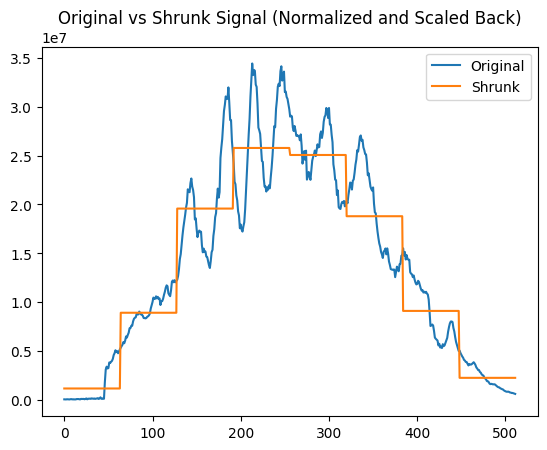

Test Segment Min/Max (Magnitude): 8624.591499060483 34446974.59536673
Normalized Test Segment Min/Max (Magnitude): 0.0002503729747058985 1.0
Shrunk Signal Min/Max (Magnitude): 1135372.9428781846 25787652.89674871


In [18]:
def mst_abs(Ssig, coarsest=3, finestlev=8):
    """
    Adaptive-Bayesian Shrinkage for one segment of complex IQ data.
    Ssig: Input complex segment (normalized to reasonable range)
    """
    # Separate real and imaginary parts
    real_part = Ssig.real
    imag_part = Ssig.imag
    
    # Step 2.1: Forward Wavelet Transform for real and imaginary parts
    wavelet = 'haar'  # Gaussian QMF approximated with Haar for simplicity
    coeffs_real = pywt.wavedec(real_part, wavelet, level=finestlev, mode='periodization')
    coeffs_imag = pywt.wavedec(imag_part, wavelet, level=finestlev, mode='periodization')
    
    # Flatten coefficients for real and imaginary parts
    datawd_real, coeff_slices = pywt.coeffs_to_array(coeffs_real)
    datawd_imag, _ = pywt.coeffs_to_array(coeffs_imag)  # Reuse coeff_slices
    
    # Print initial coefficient stats
    print("datawd_real min/max:", datawd_real.min(), datawd_real.max())
    print("datawd_imag min/max:", datawd_imag.min(), datawd_imag.max())
    
    # Step 2.2: Compute prior parameters (combine real and imaginary for statistics)
    # Use magnitude for robustness
    datawd_mag = np.sqrt(datawd_real**2 + datawd_imag**2)
    niz = datawd_mag[2**finestlev:2**(finestlev+1)]
    nizo = np.sort(np.abs(niz))
    mm = len(nizo)
    Q1 = nizo[int(mm/4)] if mm > 0 else 0
    Q3 = nizo[int(3*mm/4)] if mm > 0 else 0
    Pseudos = abs(Q1 - Q3) / 1.5
    mu = min(1 / Pseudos**2 if Pseudos != 0 else 1e-10, 1e3)  # Lower cap mu to 1e3 for testing
    
    # Scale of spread (τ) based on input signal magnitude
    sigma_d2 = np.var(np.abs(Ssig))
    tau = min(np.sqrt(max(sigma_d2 - (1/mu), 0)), 1e3)  # Cap tau at 1e3 for testing
    
    print("mu:", mu)
    print("tau:", tau)
    print("Pseudos:", Pseudos)
    print("sigma_d2:", sigma_d2)
    
    # Step 2.3: Iterative shrinkage across levels (for both real and imaginary)
    for i in range(finestlev, coarsest-1, -1):
        # Weight of point mass (ϵ)
        epsilon = min(1 - (1 / (i - coarsest + 1)**1.0), 0.9)  # Adjusted epsilon
        
        # Real part
        d_real = datawd_real[2**i:2**(i+1)] if i < finestlev else datawd_real[2**i:]
        if len(d_real) == 0:
            continue
        
        # Imaginary part
        d_imag = datawd_imag[2**i:2**(i+1)] if i < finestlev else datawd_imag[2**i:]
        
        # Compute densities and shrinkage (using magnitude for stability)
        d_mag = np.maximum(np.sqrt(d_real**2 + d_imag**2), 1e-10)  # Ensure non-negative with small epsilon
        print(f"Level {i} - d_mag min/max:", d_mag.min(), d_mag.max())
        
        de = 0.5 * np.sqrt(2*mu) * np.exp(-np.sqrt(2*mu) * d_mag)
        print(f"Level {i} - de min/max:", de.min(), de.max())
        
        m = (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-np.sqrt(2*mu)*d_mag)) / (2*tau**2 - (1/mu))
        m = np.maximum(m, 1e-10)  # Ensure non-negative with small epsilon
        print(f"Level {i} - m min/max:", m.min(), m.max())
        
        m_star = epsilon * de + (1 - epsilon) * m
        print(f"Level {i} - m_star min/max:", m_star.min(), m_star.max())
        
        # Bayes rule shrinkage (apply to real and imaginary proportionally)
        delta_mag = (tau * (tau**2 - 1/(2*mu)) * d_mag * np.exp(-d_mag/tau) + 
                     tau**2 * (np.exp(-d_mag*np.sqrt(2*mu)) - np.exp(-d_mag/tau))) / mu
        delta_mag = np.maximum(delta_mag, 0)  # Ensure non-negative
        print(f"Level {i} - delta_mag before division min/max:", delta_mag.min(), delta_mag.max())
        
        delta_mag /= ((tau**2 - 1/(2*mu)) * (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-d_mag*np.sqrt(2*mu))) + 1e-10)  # Add small epsilon
        delta_mag = np.maximum(delta_mag, 0)  # Ensure non-negative
        print(f"Level {i} - delta_mag min/max:", delta_mag.min(), delta_mag.max())
        
        delta_star = ((1 - epsilon) * m * delta_mag) / (m_star + 1e-10)  # Add small epsilon
        delta_star = np.maximum(delta_star, 0)  # Ensure non-negative
        print(f"Level {i} - delta_star min/max:", delta_star.min(), delta_star.max())
        
        # Update real and imaginary parts (scale by original magnitude direction)
        if len(d_real) > 0:
            direction = d_real + 1j * d_imag
            direction_mag = np.abs(direction)
            direction_normalized = direction / (direction_mag + 1e-10)  # Avoid division by zero
            delta_real = delta_star * direction_normalized.real
            delta_imag = delta_star * direction_normalized.imag
            
            if i < finestlev:
                datawd_real[2**i:2**(i+1)] = delta_real
                datawd_imag[2**i:2**(i+1)] = delta_imag
            else:
                datawd_real[2**i:] = delta_real
                datawd_imag[2**i:] = delta_imag
    
    # Step 2.4: Inverse Wavelet Transform for real and imaginary parts
    coeffs_updated_real = pywt.array_to_coeffs(datawd_real, coeff_slices, output_format='wavedec')
    coeffs_updated_imag = pywt.array_to_coeffs(datawd_imag, coeff_slices, output_format='wavedec')
    YSig_real = pywt.waverec(coeffs_updated_real, wavelet, mode='periodization')
    YSig_imag = pywt.waverec(coeffs_updated_imag, wavelet, mode='periodization')
    
    # Combine real and imaginary parts
    YSig = YSig_real + 1j * YSig_imag
    
    return YSig[:len(Ssig)]  # Ensure output matches input length

# Test on one segment with normalization
test_segment = segmented_data[0, 0, :]
max_magnitude = np.abs(test_segment).max()
test_segment_normalized = test_segment / (max_magnitude + 1e-10)  # Normalize to max magnitude of 1

YSig_normalized = mst_abs(test_segment_normalized)
YSig_scaled = YSig_normalized * max_magnitude  # Scale back to original magnitude range

plt.plot(np.abs(test_segment), label='Original')
plt.plot(np.abs(YSig_scaled), label='Shrunk')
plt.legend()
plt.title('Original vs Shrunk Signal (Normalized and Scaled Back)')
plt.show()

# Debug prints for input and output
print("Test Segment Min/Max (Magnitude):", np.abs(test_segment).min(), np.abs(test_segment).max())
print("Normalized Test Segment Min/Max (Magnitude):", np.abs(test_segment_normalized).min(), np.abs(test_segment_normalized).max())
print("Shrunk Signal Min/Max (Magnitude):", np.abs(YSig_scaled).min(), np.abs(YSig_scaled).max())

datawd_real min/max: -2.6036581007743145 5.353613143416054
datawd_imag min/max: -3.189156375319552 5.452333211915727
mu: 10.0
tau: 0.0
Pseudos: 0.012222336476761799
sigma_d2: 0.08416023297284166
Level 8 - d_mag min/max: 0.00034197350464643193 0.07230591348437249
Level 8 - de min/max: 1.6182690344879298 2.2326508561100815
Level 8 - m min/max: 1.6182690344879296 2.232650856110081
Level 8 - m_star min/max: 1.6182690344879298 2.2326508561100815
Level 8 - delta_mag before division min/max: 0.0 0.0
Level 8 - delta_mag min/max: 0.0 0.0
Level 8 - delta_star min/max: 0.0 0.0
Level 7 - d_mag min/max: 0.00028132833737561634 0.1330999195353399
Level 7 - de min/max: 1.2330342732813098 2.2332564631342344
Level 7 - m min/max: 1.2330342732813095 2.233256463134234
Level 7 - m_star min/max: 1.2330342732813098 2.2332564631342344
Level 7 - delta_mag before division min/max: 0.0 0.0
Level 7 - delta_mag min/max: 0.0 0.0
Level 7 - delta_star min/max: 0.0 0.0
Level 6 - d_mag min/max: 0.0005354017513443963 0.3

C:\Users\simeo\AppData\Local\Temp\ipykernel_5192\680185010.py:63: RuntimeWarning: divide by zero encountered in divide
  m = (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-np.sqrt(2*mu)*d_mag)) / (2*tau**2 - (1/mu))
C:\Users\simeo\AppData\Local\Temp\ipykernel_5192\680185010.py:71: RuntimeWarning: divide by zero encountered in divide
  delta_mag = (tau * (tau**2 - 1/(2*mu)) * d_mag * np.exp(-d_mag/tau) +
C:\Users\simeo\AppData\Local\Temp\ipykernel_5192\680185010.py:72: RuntimeWarning: divide by zero encountered in divide
  tau**2 * (np.exp(-d_mag*np.sqrt(2*mu)) - np.exp(-d_mag/tau))) / mu
C:\Users\simeo\AppData\Local\Temp\ipykernel_5192\680185010.py:76: RuntimeWarning: divide by zero encountered in divide
  delta_mag /= ((tau**2 - 1/(2*mu)) * (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-d_mag*np.sqrt(2*mu))) + 1e-10)  # Add small epsilon


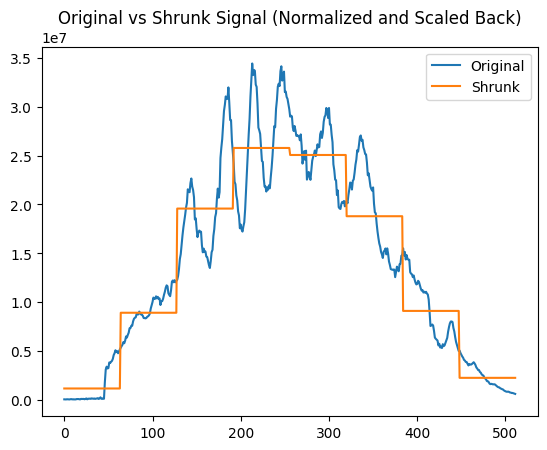

Test Segment Min/Max (Magnitude): 8624.591499060483 34446974.59536673
Normalized Test Segment Min/Max (Magnitude): 0.0002503729747058985 1.0
Shrunk Signal Min/Max (Magnitude): 1135372.9428781846 25787652.89674871


In [21]:
def mst_abs(Ssig, coarsest=3, finestlev=8):
    """
    Adaptive-Bayesian Shrinkage for one segment of complex IQ data.
    Ssig: Input complex segment (normalized to reasonable range)
    """
    # Separate real and imaginary parts
    real_part = Ssig.real
    imag_part = Ssig.imag
    
    # Step 2.1: Forward Wavelet Transform for real and imaginary parts
    wavelet = 'haar'  # Gaussian QMF approximated with Haar for simplicity
    coeffs_real = pywt.wavedec(real_part, wavelet, level=finestlev, mode='periodization')
    coeffs_imag = pywt.wavedec(imag_part, wavelet, level=finestlev, mode='periodization')
    
    # Flatten coefficients for real and imaginary parts
    datawd_real, coeff_slices = pywt.coeffs_to_array(coeffs_real)
    datawd_imag, _ = pywt.coeffs_to_array(coeffs_imag)  # Reuse coeff_slices
    
    # Print initial coefficient stats
    print("datawd_real min/max:", datawd_real.min(), datawd_real.max())
    print("datawd_imag min/max:", datawd_imag.min(), datawd_imag.max())
    
    # Step 2.2: Compute prior parameters (combine real and imaginary for statistics)
    # Use magnitude for robustness
    datawd_mag = np.sqrt(datawd_real**2 + datawd_imag**2)
    niz = datawd_mag[2**finestlev:2**(finestlev+1)]
    nizo = np.sort(np.abs(niz))
    mm = len(nizo)
    Q1 = nizo[int(mm/4)] if mm > 0 else 0
    Q3 = nizo[int(3*mm/4)] if mm > 0 else 0
    Pseudos = max(abs(Q1 - Q3) / 1.5, 1e-3)  # Ensure Pseudos is not too small
    mu = min(1 / Pseudos**2 if Pseudos != 0 else 1e-1, 10.0)  # Cap mu at 10.0 for testing
    
    # Scale of spread (τ) based on input signal magnitude
    sigma_d2 = np.var(np.abs(Ssig))
    tau = min(np.sqrt(max(sigma_d2 - (1/mu), 0)), 1.0)  # Cap tau at 1.0 for testing
    
    print("mu:", mu)
    print("tau:", tau)
    print("Pseudos:", Pseudos)
    print("sigma_d2:", sigma_d2)
    
    # Step 2.3: Iterative shrinkage across levels (for both real and imaginary)
    for i in range(finestlev, coarsest-1, -1):
        # Weight of point mass (ϵ)
        epsilon = min(1 - (1 / (i - coarsest + 1)**1.0), 0.9)  # Adjusted epsilon
        
        # Real part
        d_real = datawd_real[2**i:2**(i+1)] if i < finestlev else datawd_real[2**i:]
        if len(d_real) == 0:
            continue
        
        # Imaginary part
        d_imag = datawd_imag[2**i:2**(i+1)] if i < finestlev else datawd_imag[2**i:]
        
        # Compute densities and shrinkage (using magnitude for stability)
        d_mag = np.maximum(np.sqrt(d_real**2 + d_imag**2), 1e-10)  # Ensure non-negative with small epsilon
        print(f"Level {i} - d_mag min/max:", d_mag.min(), d_mag.max())
        
        de = 0.5 * np.sqrt(2*mu) * np.exp(-np.sqrt(2*mu) * d_mag)
        print(f"Level {i} - de min/max:", de.min(), de.max())
        
        m = (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-np.sqrt(2*mu)*d_mag)) / (2*tau**2 - (1/mu))
        m = np.maximum(m, 1e-10)  # Ensure non-negative with small epsilon
        print(f"Level {i} - m min/max:", m.min(), m.max())
        
        m_star = epsilon * de + (1 - epsilon) * m
        print(f"Level {i} - m_star min/max:", m_star.min(), m_star.max())
        
        # Bayes rule shrinkage (apply to real and imaginary proportionally)
        delta_mag = (tau * (tau**2 - 1/(2*mu)) * d_mag * np.exp(-d_mag/tau) + 
                     tau**2 * (np.exp(-d_mag*np.sqrt(2*mu)) - np.exp(-d_mag/tau))) / mu
        delta_mag = np.maximum(delta_mag, 0)  # Ensure non-negative
        print(f"Level {i} - delta_mag before division min/max:", delta_mag.min(), delta_mag.max())
        
        delta_mag /= ((tau**2 - 1/(2*mu)) * (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-d_mag*np.sqrt(2*mu))) + 1e-10)  # Add small epsilon
        delta_mag = np.maximum(delta_mag, 0)  # Ensure non-negative
        print(f"Level {i} - delta_mag min/max:", delta_mag.min(), delta_mag.max())
        
        delta_star = ((1 - epsilon) * m * delta_mag) / (m_star + 1e-10)  # Add small epsilon
        delta_star = np.maximum(delta_star, 0)  # Ensure non-negative
        print(f"Level {i} - delta_star min/max:", delta_star.min(), delta_star.max())
        
        # Update real and imaginary parts (scale by original magnitude direction)
        if len(d_real) > 0:
            direction = d_real + 1j * d_imag
            direction_mag = np.abs(direction)
            direction_normalized = direction / (direction_mag + 1e-10)  # Avoid division by zero
            delta_real = delta_star * direction_normalized.real
            delta_imag = delta_star * direction_normalized.imag
            
            if i < finestlev:
                datawd_real[2**i:2**(i+1)] = delta_real
                datawd_imag[2**i:2**(i+1)] = delta_imag
            else:
                datawd_real[2**i:] = delta_real
                datawd_imag[2**i:] = delta_imag
    
    # Step 2.4: Inverse Wavelet Transform for real and imaginary parts
    coeffs_updated_real = pywt.array_to_coeffs(datawd_real, coeff_slices, output_format='wavedec')
    coeffs_updated_imag = pywt.array_to_coeffs(datawd_imag, coeff_slices, output_format='wavedec')
    YSig_real = pywt.waverec(coeffs_updated_real, wavelet, mode='periodization')
    YSig_imag = pywt.waverec(coeffs_updated_imag, wavelet, mode='periodization')
    
    # Combine real and imaginary parts
    YSig = YSig_real + 1j * YSig_imag
    
    return YSig[:len(Ssig)]  # Ensure output matches input length

# Test on one segment with normalization
test_segment = segmented_data[0, 0, :]
max_magnitude = np.abs(test_segment).max()
test_segment_normalized = test_segment / (max_magnitude + 1e-10)  # Normalize to max magnitude of 1

YSig_normalized = mst_abs(test_segment_normalized)
YSig_scaled = YSig_normalized * max_magnitude  # Scale back to original magnitude range

plt.plot(np.abs(test_segment), label='Original')
plt.plot(np.abs(YSig_scaled), label='Shrunk')
plt.legend()
plt.title('Original vs Shrunk Signal (Normalized and Scaled Back)')
plt.show()

# Debug prints for input and output
print("Test Segment Min/Max (Magnitude):", np.abs(test_segment).min(), np.abs(test_segment).max())
print("Normalized Test Segment Min/Max (Magnitude):", np.abs(test_segment_normalized).min(), np.abs(test_segment_normalized).max())
print("Shrunk Signal Min/Max (Magnitude):", np.abs(YSig_scaled).min(), np.abs(YSig_scaled).max())

datawd_real min/max: -2.6036581007743145 5.353613143416054
datawd_imag min/max: -3.189156375319552 5.452333211915727
mu: 10.0
tau: 0.1
Pseudos: 0.012222336476761799
sigma_d2: 0.08416023297284166
Level 8 - d_mag min/max: 0.00034197350464643193 0.07230591348437249
Level 8 - de min/max: 1.6182690344879298 2.2326508561100815
Level 8 - m min/max: 1.4162544300585724 1.5450809381529447
Level 8 - m_star min/max: 1.5845999337497036 2.118055869783892
Level 8 - delta_mag before division min/max: 1.7493888520392224e-06 0.00022441139713100757
Level 8 - delta_mag min/max: 0.00035382224432775746 0.04951692193692606
Level 8 - delta_star min/max: 4.301775140263258e-05 0.007376053155749573
Level 7 - d_mag min/max: 0.00028132833737561634 0.1330999195353399
Level 7 - de min/max: 1.2330342732813098 2.2332564631342344
Level 7 - m min/max: 1.2110264305626408 1.54508224116837
Level 7 - m_star min/max: 1.228632704737576 2.0956216187410615
Level 7 - delta_mag before division min/max: 1.4397671549247023e-06 0.00

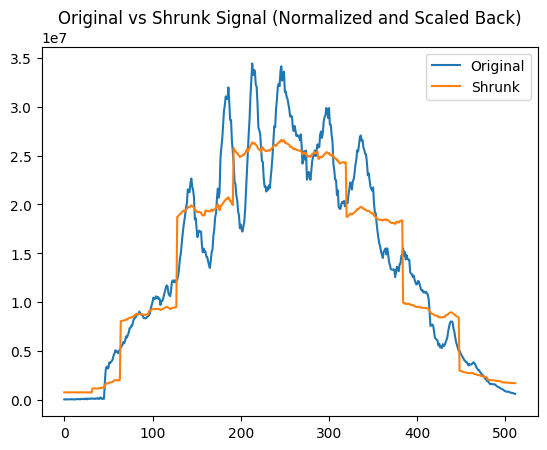

Test Segment Min/Max (Magnitude): 8624.591499060483 34446974.59536673
Normalized Test Segment Min/Max (Magnitude): 0.0002503729747058985 1.0
Shrunk Signal Min/Max (Magnitude): 716769.0970785414 26616860.82998461


In [22]:
def mst_abs(Ssig, coarsest=3, finestlev=8):
    """
    Adaptive-Bayesian Shrinkage for one segment of complex IQ data.
    Ssig: Input complex segment (normalized to reasonable range)
    """
    # Separate real and imaginary parts
    real_part = Ssig.real
    imag_part = Ssig.imag
    
    # Step 2.1: Forward Wavelet Transform for real and imaginary parts
    wavelet = 'haar'  # Gaussian QMF approximated with Haar for simplicity
    coeffs_real = pywt.wavedec(real_part, wavelet, level=finestlev, mode='periodization')
    coeffs_imag = pywt.wavedec(imag_part, wavelet, level=finestlev, mode='periodization')
    
    # Flatten coefficients for real and imaginary parts
    datawd_real, coeff_slices = pywt.coeffs_to_array(coeffs_real)
    datawd_imag, _ = pywt.coeffs_to_array(coeffs_imag)  # Reuse coeff_slices
    
    # Print initial coefficient stats
    print("datawd_real min/max:", datawd_real.min(), datawd_real.max())
    print("datawd_imag min/max:", datawd_imag.min(), datawd_imag.max())
    
    # Step 2.2: Compute prior parameters (combine real and imaginary for statistics)
    # Use magnitude for robustness
    datawd_mag = np.sqrt(datawd_real**2 + datawd_imag**2)
    niz = datawd_mag[2**finestlev:2**(finestlev+1)]
    nizo = np.sort(np.abs(niz))
    mm = len(nizo)
    Q1 = nizo[int(mm/4)] if mm > 0 else 0
    Q3 = nizo[int(3*mm/4)] if mm > 0 else 0
    Pseudos = max(abs(Q1 - Q3) / 1.5, 1e-3)  # Ensure Pseudos is not too small
    mu = min(1 / Pseudos**2 if Pseudos != 0 else 1e-1, 10.0)  # Cap mu at 10.0
    
    # Scale of spread (τ) based on input signal magnitude
    sigma_d2 = np.var(np.abs(Ssig))
    tau = max(np.sqrt(max(sigma_d2 - (1/mu), 1e-6)), 0.1)  # Ensure tau is at least 0.1, with a minimum of 1e-6 for stability
    
    print("mu:", mu)
    print("tau:", tau)
    print("Pseudos:", Pseudos)
    print("sigma_d2:", sigma_d2)
    
    # Step 2.3: Iterative shrinkage across levels (for both real and imaginary)
    for i in range(finestlev, coarsest-1, -1):
        # Weight of point mass (ϵ)
        epsilon = min(1 - (1 / (i - coarsest + 1)**1.0), 0.9)  # Adjusted epsilon
        
        # Real part
        d_real = datawd_real[2**i:2**(i+1)] if i < finestlev else datawd_real[2**i:]
        if len(d_real) == 0:
            continue
        
        # Imaginary part
        d_imag = datawd_imag[2**i:2**(i+1)] if i < finestlev else datawd_imag[2**i:]
        
        # Compute densities and shrinkage (using magnitude for stability)
        d_mag = np.maximum(np.sqrt(d_real**2 + d_imag**2), 1e-10)  # Ensure non-negative with small epsilon
        print(f"Level {i} - d_mag min/max:", d_mag.min(), d_mag.max())
        
        de = 0.5 * np.sqrt(2*mu) * np.exp(-np.sqrt(2*mu) * d_mag)
        print(f"Level {i} - de min/max:", de.min(), de.max())
        
        m = (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-np.sqrt(2*mu)*d_mag)) / (2*tau**2 - (1/mu))
        m = np.maximum(m, 1e-10)  # Ensure non-negative with small epsilon
        print(f"Level {i} - m min/max:", m.min(), m.max())
        
        m_star = epsilon * de + (1 - epsilon) * m
        print(f"Level {i} - m_star min/max:", m_star.min(), m_star.max())
        
        # Bayes rule shrinkage (apply to real and imaginary proportionally)
        delta_mag = (tau * (tau**2 - 1/(2*mu)) * d_mag * np.exp(-d_mag/tau) + 
                     tau**2 * (np.exp(-d_mag*np.sqrt(2*mu)) - np.exp(-d_mag/tau))) / mu
        delta_mag = np.maximum(delta_mag, 0)  # Ensure non-negative
        print(f"Level {i} - delta_mag before division min/max:", delta_mag.min(), delta_mag.max())
        
        delta_mag /= ((tau**2 - 1/(2*mu)) * (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-d_mag*np.sqrt(2*mu))) + 1e-10)  # Add small epsilon
        delta_mag = np.maximum(delta_mag, 0)  # Ensure non-negative
        print(f"Level {i} - delta_mag min/max:", delta_mag.min(), delta_mag.max())
        
        delta_star = ((1 - epsilon) * m * delta_mag) / (m_star + 1e-10)  # Add small epsilon
        delta_star = np.maximum(delta_star, 0)  # Ensure non-negative
        print(f"Level {i} - delta_star min/max:", delta_star.min(), delta_star.max())
        
        # Update real and imaginary parts (scale by original magnitude direction)
        if len(d_real) > 0:
            direction = d_real + 1j * d_imag
            direction_mag = np.abs(direction)
            direction_normalized = direction / (direction_mag + 1e-10)  # Avoid division by zero
            delta_real = delta_star * direction_normalized.real
            delta_imag = delta_star * direction_normalized.imag
            
            if i < finestlev:
                datawd_real[2**i:2**(i+1)] = delta_real
                datawd_imag[2**i:2**(i+1)] = delta_imag
            else:
                datawd_real[2**i:] = delta_real
                datawd_imag[2**i:] = delta_imag
    
    # Step 2.4: Inverse Wavelet Transform for real and imaginary parts
    coeffs_updated_real = pywt.array_to_coeffs(datawd_real, coeff_slices, output_format='wavedec')
    coeffs_updated_imag = pywt.array_to_coeffs(datawd_imag, coeff_slices, output_format='wavedec')
    YSig_real = pywt.waverec(coeffs_updated_real, wavelet, mode='periodization')
    YSig_imag = pywt.waverec(coeffs_updated_imag, wavelet, mode='periodization')
    
    # Combine real and imaginary parts
    YSig = YSig_real + 1j * YSig_imag
    
    return YSig[:len(Ssig)]  # Ensure output matches input length

# Test on one segment with normalization
test_segment = segmented_data[0, 0, :]
max_magnitude = np.abs(test_segment).max()
test_segment_normalized = test_segment / (max_magnitude + 1e-10)  # Normalize to max magnitude of 1

YSig_normalized = mst_abs(test_segment_normalized)
YSig_scaled = YSig_normalized * max_magnitude  # Scale back to original magnitude range

plt.plot(np.abs(test_segment), label='Original')
plt.plot(np.abs(YSig_scaled), label='Shrunk')
plt.legend()
plt.title('Original vs Shrunk Signal (Normalized and Scaled Back)')
plt.show()

# Debug prints for input and output
print("Test Segment Min/Max (Magnitude):", np.abs(test_segment).min(), np.abs(test_segment).max())
print("Normalized Test Segment Min/Max (Magnitude):", np.abs(test_segment_normalized).min(), np.abs(test_segment_normalized).max())
print("Shrunk Signal Min/Max (Magnitude):", np.abs(YSig_scaled).min(), np.abs(YSig_scaled).max())

c:\Users\simeo\Desktop\shreya\MST_Radar_ABS\.venv\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  warnings.warn(


datawd_real min/max: -1.0553372175766693 7.561931421896191
datawd_imag min/max: -3.081941774503368 6.079250490976105
mu: 20.0
tau: 0.18482487108839452
Pseudos: 0.007968742396702056
sigma_d2: 0.08416023297284166
Level 8 - d_mag min/max: 5.1107388732999184e-05 0.04091511282424332
Level 8 - de min/max: 2.4412803908063556 3.161255677571105
Level 8 - m min/max: 1.4223438259787538 1.4579862196574247
Level 8 - m_star min/max: 2.135599421358075 2.6502748401970013
Level 8 - delta_mag before division min/max: 0.0 0.0
Level 8 - delta_mag min/max: 0.0 0.0
Level 8 - delta_star min/max: 0.0 0.0
Level 7 - d_mag min/max: 0.00019932172739171768 0.05341585958424267
Level 7 - de min/max: 2.2557014470392005 3.1582937372571607
Level 7 - m min/max: 1.4000686232414532 1.4579852945082872
Level 7 - m_star min/max: 1.9990115998998763 2.6482012044324987
Level 7 - delta_mag before division min/max: 0.0 0.0
Level 7 - delta_mag min/max: 0.0 0.0
Level 7 - delta_star min/max: 0.0 0.0
Level 6 - d_mag min/max: 0.001735

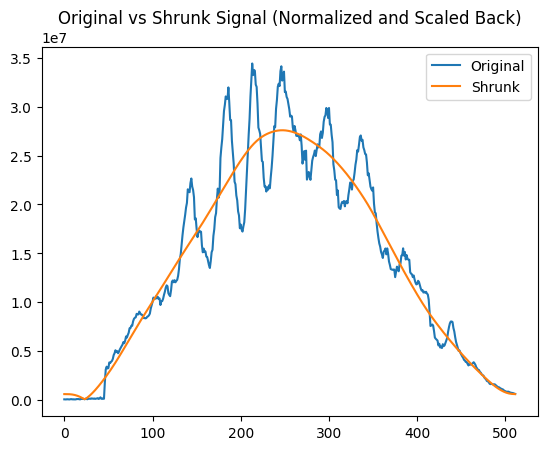

Test Segment Min/Max (Magnitude): 8624.591499060483 34446974.59536673
Normalized Test Segment Min/Max (Magnitude): 0.0002503729747058985 1.0
Shrunk Signal Min/Max (Magnitude): 39968.42046117025 27602676.775299933
YSig_normalized min/max (Magnitude): 0.001160288267131192 0.8013091744496079


In [23]:
def mst_abs(Ssig, coarsest=3, finestlev=8):
    """
    Adaptive-Bayesian Shrinkage for one segment of complex IQ data.
    Ssig: Input complex segment (normalized to reasonable range)
    """
    # Separate real and imaginary parts
    real_part = Ssig.real
    imag_part = Ssig.imag
    
    # Step 2.1: Forward Wavelet Transform for real and imaginary parts
    # wavelet = 'haar'  # Gaussian QMF approximated with Haar for simplicity
    wavelet = 'db8'  # Try Daubechies 8
    coeffs_real = pywt.wavedec(real_part, wavelet, level=finestlev, mode='periodization')
    coeffs_imag = pywt.wavedec(imag_part, wavelet, level=finestlev, mode='periodization')
    
    # Flatten coefficients for real and imaginary parts
    datawd_real, coeff_slices = pywt.coeffs_to_array(coeffs_real)
    datawd_imag, _ = pywt.coeffs_to_array(coeffs_imag)  # Reuse coeff_slices
    
    # Print initial coefficient stats
    print("datawd_real min/max:", datawd_real.min(), datawd_real.max())
    print("datawd_imag min/max:", datawd_imag.min(), datawd_imag.max())
    
    # Step 2.2: Compute prior parameters (combine real and imaginary for statistics)
    # Use magnitude for robustness
    datawd_mag = np.sqrt(datawd_real**2 + datawd_imag**2)
    niz = datawd_mag[2**finestlev:2**(finestlev+1)]
    nizo = np.sort(np.abs(niz))
    mm = len(nizo)
    Q1 = nizo[int(mm/4)] if mm > 0 else 0
    Q3 = nizo[int(3*mm/4)] if mm > 0 else 0
    Pseudos = max(abs(Q1 - Q3) / 1.5, 1e-3)  # Ensure Pseudos is not too small
    # mu = min(1 / Pseudos**2 if Pseudos != 0 else 1e-1, 10.0)  # Cap mu at 10.0
    mu = min(1 / Pseudos**2 if Pseudos != 0 else 1e-1, 20.0)  # Cap mu at 20.0
    
    # Scale of spread (τ) based on input signal magnitude
    sigma_d2 = np.var(np.abs(Ssig))
    # tau = max(np.sqrt(max(sigma_d2 - (1/mu), 1e-6)), 0.1)  # Ensure tau is at least 0.1, with a minimum of 1e-6 for stability
    tau = max(np.sqrt(max(sigma_d2 - (1/mu), 1e-6)), 0.05)  # Ensure tau is at least 0.05
    
    print("mu:", mu)
    print("tau:", tau)
    print("Pseudos:", Pseudos)
    print("sigma_d2:", sigma_d2)
    
    # Step 2.3: Iterative shrinkage across levels (for both real and imaginary)
    for i in range(finestlev, coarsest-1, -1):
        # Weight of point mass (ϵ)
        # epsilon = min(1 - (1 / (i - coarsest + 1)**1.0), 0.9)  # Adjusted epsilon
        epsilon = min(1 - (1 / (i - coarsest + 1)**1.0), 0.7)  # Lower cap to 0.7
        
        # Real part
        d_real = datawd_real[2**i:2**(i+1)] if i < finestlev else datawd_real[2**i:]
        if len(d_real) == 0:
            continue
        
        # Imaginary part
        d_imag = datawd_imag[2**i:2**(i+1)] if i < finestlev else datawd_imag[2**i:]
        
        # Compute densities and shrinkage (using magnitude for stability)
        d_mag = np.maximum(np.sqrt(d_real**2 + d_imag**2), 1e-10)  # Ensure non-negative with small epsilon
        print(f"Level {i} - d_mag min/max:", d_mag.min(), d_mag.max())
        
        de = 0.5 * np.sqrt(2*mu) * np.exp(-np.sqrt(2*mu) * d_mag)
        print(f"Level {i} - de min/max:", de.min(), de.max())
        
        m = (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-np.sqrt(2*mu)*d_mag)) / (2*tau**2 - (1/mu))
        m = np.maximum(m, 1e-10)  # Ensure non-negative with small epsilon
        print(f"Level {i} - m min/max:", m.min(), m.max())
        
        m_star = epsilon * de + (1 - epsilon) * m
        print(f"Level {i} - m_star min/max:", m_star.min(), m_star.max())
        
        # Bayes rule shrinkage (apply to real and imaginary proportionally)
        delta_mag = (tau * (tau**2 - 1/(2*mu)) * d_mag * np.exp(-d_mag/tau) + 
                     tau**2 * (np.exp(-d_mag*np.sqrt(2*mu)) - np.exp(-d_mag/tau))) / mu
        delta_mag = np.maximum(delta_mag, 0)  # Ensure non-negative
        print(f"Level {i} - delta_mag before division min/max:", delta_mag.min(), delta_mag.max())
        
        delta_mag /= ((tau**2 - 1/(2*mu)) * (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-d_mag*np.sqrt(2*mu))) + 1e-10)  # Add small epsilon
        delta_mag = np.maximum(delta_mag, 0)  # Ensure non-negative
        print(f"Level {i} - delta_mag min/max:", delta_mag.min(), delta_mag.max())
        
        delta_star = ((1 - epsilon) * m * delta_mag) / (m_star + 1e-10)  # Add small epsilon
        delta_star = np.maximum(delta_star, 0)  # Ensure non-negative
        print(f"Level {i} - delta_star min/max:", delta_star.min(), delta_star.max())
        
        # Update real and imaginary parts (scale by original magnitude direction)
        if len(d_real) > 0:
            direction = d_real + 1j * d_imag
            direction_mag = np.abs(direction)
            direction_normalized = direction / (direction_mag + 1e-10)  # Avoid division by zero
            delta_real = delta_star * direction_normalized.real
            delta_imag = delta_star * direction_normalized.imag
            
            if i < finestlev:
                datawd_real[2**i:2**(i+1)] = delta_real
                datawd_imag[2**i:2**(i+1)] = delta_imag
            else:
                datawd_real[2**i:] = delta_real
                datawd_imag[2**i:] = delta_imag
    
    # Step 2.4: Inverse Wavelet Transform for real and imaginary parts
    coeffs_updated_real = pywt.array_to_coeffs(datawd_real, coeff_slices, output_format='wavedec')
    coeffs_updated_imag = pywt.array_to_coeffs(datawd_imag, coeff_slices, output_format='wavedec')
    YSig_real = pywt.waverec(coeffs_updated_real, wavelet, mode='periodization')
    YSig_imag = pywt.waverec(coeffs_updated_imag, wavelet, mode='periodization')
    
    # Combine real and imaginary parts
    YSig = YSig_real + 1j * YSig_imag
    
    return YSig[:len(Ssig)]  # Ensure output matches input length

# Test on one segment with normalization
test_segment = segmented_data[0, 0, :]
max_magnitude = np.abs(test_segment).max()
test_segment_normalized = test_segment / (max_magnitude + 1e-10)  # Normalize to max magnitude of 1

YSig_normalized = mst_abs(test_segment_normalized)
YSig_scaled = YSig_normalized * max_magnitude  # Scale back to original magnitude range

plt.plot(np.abs(test_segment), label='Original')
plt.plot(np.abs(YSig_scaled), label='Shrunk')
plt.legend()
plt.title('Original vs Shrunk Signal (Normalized and Scaled Back)')
plt.show()

# Debug prints for input and output
print("Test Segment Min/Max (Magnitude):", np.abs(test_segment).min(), np.abs(test_segment).max())
print("Normalized Test Segment Min/Max (Magnitude):", np.abs(test_segment_normalized).min(), np.abs(test_segment_normalized).max())
print("Shrunk Signal Min/Max (Magnitude):", np.abs(YSig_scaled).min(), np.abs(YSig_scaled).max())
print("YSig_normalized min/max (Magnitude):", np.abs(YSig_normalized).min(), np.abs(YSig_normalized).max())

c:\Users\simeo\Desktop\shreya\MST_Radar_ABS\.venv\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 6 is too high: all coefficients will experience boundary effects.
  warnings.warn(


datawd_real min/max: -1.0553372175766693 4.610076503142105
datawd_imag min/max: -0.8104243295971448 4.762080373254552
mu: 10.0
tau: 0.2
Pseudos: 0.024838328017140365
sigma_d2: 0.08416023297284166
Level 6 - d_mag min/max: 5.1107388732999184e-05 0.12141231704716644
Level 6 - de min/max: 1.2991972422499825 2.2355569620133275
Level 6 - m min/max before clamp: 1.0464881381329136 1.1803398530354468
Level 6 - m min/max: 1.0464881381329136 1.1803398530354468
Level 6 - m_star min/max: 1.1728426901914482 1.7079484075243871
Level 6 - delta_mag before division min/max: 9.766602918089145e-08 0.0001310427268781543
Level 6 - delta_mag min/max: 0.0004137197755279936 0.6261067827356134
Level 6 - delta_star min/max: 0.0001429580474634465 0.27932702602024234
Level 5 - d_mag min/max: 0.011332439123240758 0.5190478496828128
Level 5 - de min/max: 0.2194713465299869 2.125567334652348
Level 5 - m min/max before clamp: 0.3510765396183779 1.1787045604137603
Level 5 - m min/max: 0.3510765396183779 1.178704560413

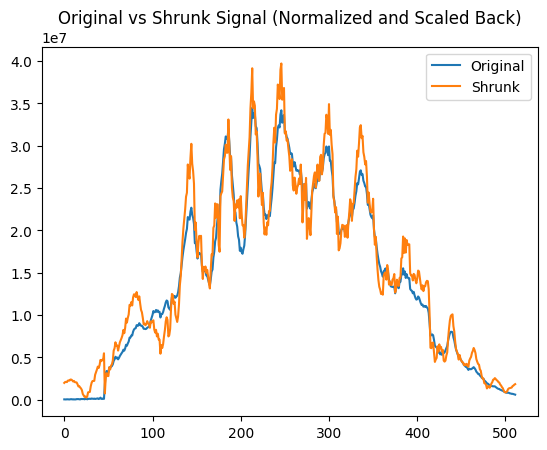

Test Segment Min/Max (Magnitude): 8624.591499060483 34446974.59536673
Normalized Test Segment Min/Max (Magnitude): 0.0002503729747058985 1.0
Shrunk Signal Min/Max (Magnitude): 233366.39612105858 39688358.05433897


In [24]:
def mst_abs(Ssig, coarsest=3, finestlev=6):  # Reduced finestlev to 6 to avoid boundary effects
    """
    Adaptive-Bayesian Shrinkage for one segment of complex IQ data.
    Ssig: Input complex segment (normalized to reasonable range)
    """
    # Separate real and imaginary parts
    real_part = Ssig.real
    imag_part = Ssig.imag
    
    # Step 2.1: Forward Wavelet Transform for real and imaginary parts
    wavelet = 'db8'  # Switch to Daubechies 8 for better signal representation
    coeffs_real = pywt.wavedec(real_part, wavelet, level=finestlev, mode='periodization')
    coeffs_imag = pywt.wavedec(imag_part, wavelet, level=finestlev, mode='periodization')
    
    # Flatten coefficients for real and imaginary parts
    datawd_real, coeff_slices = pywt.coeffs_to_array(coeffs_real)
    datawd_imag, _ = pywt.coeffs_to_array(coeffs_imag)  # Reuse coeff_slices
    
    # Print initial coefficient stats
    print("datawd_real min/max:", datawd_real.min(), datawd_real.max())
    print("datawd_imag min/max:", datawd_imag.min(), datawd_imag.max())
    
    # Step 2.2: Compute prior parameters (combine real and imaginary for statistics)
    # Use magnitude for robustness
    datawd_mag = np.sqrt(datawd_real**2 + datawd_imag**2)
    niz = datawd_mag[2**finestlev:2**(finestlev+1)]
    nizo = np.sort(np.abs(niz))
    mm = len(nizo)
    Q1 = nizo[int(mm/4)] if mm > 0 else 0
    Q3 = nizo[int(3*mm/4)] if mm > 0 else 0
    Pseudos = max(abs(Q1 - Q3) / 1.5, 1e-3)  # Ensure Pseudos is not too small
    mu = min(1 / Pseudos**2 if Pseudos != 0 else 1e-1, 10.0)  # Reduce mu to 10.0 for testing
    
    # Scale of spread (τ) based on input signal magnitude
    sigma_d2 = np.var(np.abs(Ssig))
    tau = max(np.sqrt(max(sigma_d2 - (1/mu), 1e-6)), 0.2)  # Increase tau to 0.2 for stability
    
    print("mu:", mu)
    print("tau:", tau)
    print("Pseudos:", Pseudos)
    print("sigma_d2:", sigma_d2)
    
    # Step 2.3: Iterative shrinkage across levels (for both real and imaginary)
    for i in range(finestlev, coarsest-1, -1):
        # Weight of point mass (ϵ)
        epsilon = min(1 - (1 / (i - coarsest + 1)**1.0), 0.5)  # Lower epsilon cap to 0.5 for more shrinkage
        
        # Real part
        d_real = datawd_real[2**i:2**(i+1)] if i < finestlev else datawd_real[2**i:]
        if len(d_real) == 0:
            continue
        
        # Imaginary part
        d_imag = datawd_imag[2**i:2**(i+1)] if i < finestlev else datawd_imag[2**i:]
        
        # Compute densities and shrinkage (using magnitude for stability)
        d_mag = np.maximum(np.sqrt(d_real**2 + d_imag**2), 1e-10)  # Ensure non-negative with small epsilon
        print(f"Level {i} - d_mag min/max:", d_mag.min(), d_mag.max())
        
        de = 0.5 * np.sqrt(2*mu) * np.exp(-np.sqrt(2*mu) * d_mag)
        print(f"Level {i} - de min/max:", de.min(), de.max())
        
        m = (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-np.sqrt(2*mu)*d_mag)) / (2*tau**2 - (1/mu))
        m = np.maximum(m, 1e-10)  # Ensure non-negative with small epsilon
        print(f"Level {i} - m min/max before clamp:", m.min(), m.max())  # Debug before clamping
        
        m = np.clip(m, 1e-10, None)  # Clip very small values to prevent underflow
        print(f"Level {i} - m min/max:", m.min(), m.max())
        
        m_star = epsilon * de + (1 - epsilon) * m
        print(f"Level {i} - m_star min/max:", m_star.min(), m_star.max())
        
        # Bayes rule shrinkage (apply to real and imaginary proportionally)
        delta_mag = (tau * (tau**2 - 1/(2*mu)) * d_mag * np.exp(-d_mag/tau) + 
                     tau**2 * (np.exp(-d_mag*np.sqrt(2*mu)) - np.exp(-d_mag/tau))) / mu
        delta_mag = np.maximum(delta_mag, 0)  # Ensure non-negative
        print(f"Level {i} - delta_mag before division min/max:", delta_mag.min(), delta_mag.max())
        
        delta_mag /= ((tau**2 - 1/(2*mu)) * (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-d_mag*np.sqrt(2*mu))) + 1e-10)  # Add small epsilon
        delta_mag = np.maximum(delta_mag, 0)  # Ensure non-negative
        print(f"Level {i} - delta_mag min/max:", delta_mag.min(), delta_mag.max())
        
        delta_star = ((1 - epsilon) * m * delta_mag) / (m_star + 1e-10)  # Add small epsilon
        delta_star = np.maximum(delta_star, 0)  # Ensure non-negative
        print(f"Level {i} - delta_star min/max:", delta_star.min(), delta_star.max())
        
        # Update real and imaginary parts (scale by original magnitude direction)
        if len(d_real) > 0:
            direction = d_real + 1j * d_imag
            direction_mag = np.abs(direction)
            direction_normalized = direction / (direction_mag + 1e-10)  # Avoid division by zero
            delta_real = delta_star * direction_normalized.real
            delta_imag = delta_star * direction_normalized.imag
            
            if i < finestlev:
                datawd_real[2**i:2**(i+1)] = delta_real
                datawd_imag[2**i:2**(i+1)] = delta_imag
            else:
                datawd_real[2**i:] = delta_real
                datawd_imag[2**i:] = delta_imag
    
    # Step 2.4: Inverse Wavelet Transform for real and imaginary parts
    coeffs_updated_real = pywt.array_to_coeffs(datawd_real, coeff_slices, output_format='wavedec')
    coeffs_updated_imag = pywt.array_to_coeffs(datawd_imag, coeff_slices, output_format='wavedec')
    YSig_real = pywt.waverec(coeffs_updated_real, wavelet, mode='periodization')
    YSig_imag = pywt.waverec(coeffs_updated_imag, wavelet, mode='periodization')
    
    # Combine real and imaginary parts
    YSig = YSig_real + 1j * YSig_imag
    
    return YSig[:len(Ssig)]  # Ensure output matches input length

# Test on one segment with normalization
test_segment = segmented_data[0, 0, :]
max_magnitude = np.abs(test_segment).max()
test_segment_normalized = test_segment / (max_magnitude + 1e-10)  # Normalize to max magnitude of 1

YSig_normalized = mst_abs(test_segment_normalized)
YSig_scaled = YSig_normalized * max_magnitude  # Scale back to original magnitude range

plt.plot(np.abs(test_segment), label='Original')
plt.plot(np.abs(YSig_scaled), label='Shrunk')
plt.legend()
plt.title('Original vs Shrunk Signal (Normalized and Scaled Back)')
plt.show()

# Debug prints for input and output
print("Test Segment Min/Max (Magnitude):", np.abs(test_segment).min(), np.abs(test_segment).max())
print("Normalized Test Segment Min/Max (Magnitude):", np.abs(test_segment_normalized).min(), np.abs(test_segment_normalized).max())
print("Shrunk Signal Min/Max (Magnitude):", np.abs(YSig_scaled).min(), np.abs(YSig_scaled).max())

datawd_real min/max: -1.0553372175766693 3.5020615367890557
datawd_imag min/max: -0.8104243295971448 3.3155495557332877
mu: 30.0
tau: 0.2254482194196892
Pseudos: 0.11334508597249071
sigma_d2: 0.08416023297284166
Level 5 - d_mag min/max: 5.1107388732999184e-05 0.5190478496828128
Level 5 - de min/max: 0.06949487606160945 3.8714504279883135
Level 5 - m min/max: 0.2961764489560206 1.4102475574498465
Level 5 - m_star min/max: 0.2281719770876972 2.1486084186113867
Level 5 - delta_mag before division min/max: 0.0 0.0
Level 5 - delta_mag min/max: 0.0 0.0
Level 5 - delta_star min/max: 0.0 0.0
Level 4 - d_mag min/max: 0.05543855886985573 1.330610475235126
Level 4 - de min/max: 0.00012936931703635732 2.52085938724059
Level 4 - m min/max: 0.008958010276617863 1.350565994749018
Level 4 - m_star min/max: 0.00630941798874341 1.7016540124964896
Level 4 - delta_mag before division min/max: 0.0 0.0
Level 4 - delta_mag min/max: 0.0 0.0
Level 4 - delta_star min/max: 0.0 0.0
Level 3 - d_mag min/max: 1.2832

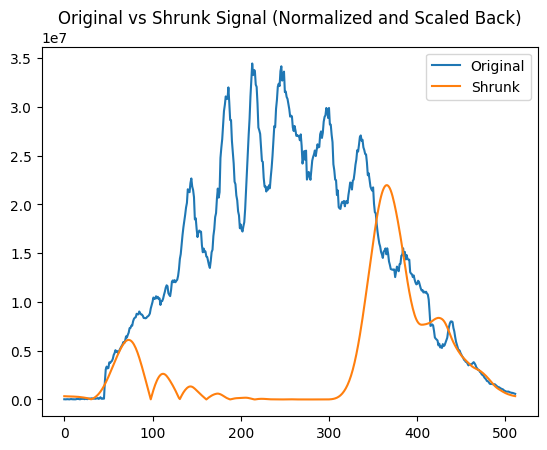

Test Segment Min/Max (Magnitude): 8624.591499060483 34446974.59536673
Normalized Test Segment Min/Max (Magnitude): 0.0002503729747058985 1.0
Shrunk Signal Min/Max (Magnitude): 56.434383512041705 21969261.87731149
YSig_normalized min/max (Magnitude): 1.6382972430801622e-06 0.6377704322476683


In [25]:
def mst_abs(Ssig, coarsest=3, finestlev=5):  # Further reduce finestlev to 5 to minimize boundary effects
    """
    Adaptive-Bayesian Shrinkage for one segment of complex IQ data.
    Ssig: Input complex segment (normalized to reasonable range)
    """
    # Separate real and imaginary parts
    real_part = Ssig.real
    imag_part = Ssig.imag
    
    # Step 2.1: Forward Wavelet Transform for real and imaginary parts
    wavelet = 'db8'  # Keep Daubechies 8 for better signal representation
    coeffs_real = pywt.wavedec(real_part, wavelet, level=finestlev, mode='periodization')
    coeffs_imag = pywt.wavedec(imag_part, wavelet, level=finestlev, mode='periodization')
    
    # Flatten coefficients for real and imaginary parts
    datawd_real, coeff_slices = pywt.coeffs_to_array(coeffs_real)
    datawd_imag, _ = pywt.coeffs_to_array(coeffs_imag)  # Reuse coeff_slices
    
    # Print initial coefficient stats
    print("datawd_real min/max:", datawd_real.min(), datawd_real.max())
    print("datawd_imag min/max:", datawd_imag.min(), datawd_imag.max())
    
    # Step 2.2: Compute prior parameters (combine real and imaginary for statistics)
    # Use magnitude for robustness
    datawd_mag = np.sqrt(datawd_real**2 + datawd_imag**2)
    niz = datawd_mag[2**finestlev:2**(finestlev+1)]
    nizo = np.sort(np.abs(niz))
    mm = len(nizo)
    Q1 = nizo[int(mm/4)] if mm > 0 else 0
    Q3 = nizo[int(3*mm/4)] if mm > 0 else 0
    Pseudos = max(abs(Q1 - Q3) / 1.5, 1e-3)  # Ensure Pseudos is not too small
    mu = min(1 / Pseudos**2 if Pseudos != 0 else 1e-1, 30.0)  # Increase mu to 30.0 for more shrinkage
    
    # Scale of spread (τ) based on input signal magnitude
    sigma_d2 = np.var(np.abs(Ssig))
    tau = max(np.sqrt(max(sigma_d2 - (1/mu), 1e-6)), 0.05)  # Decrease tau to 0.05 for tighter spread
    
    print("mu:", mu)
    print("tau:", tau)
    print("Pseudos:", Pseudos)
    print("sigma_d2:", sigma_d2)
    
    # Step 2.3: Iterative shrinkage across levels (for both real and imaginary)
    for i in range(finestlev, coarsest-1, -1):
        # Weight of point mass (ϵ)
        epsilon = min(1 - (1 / (i - coarsest + 1)**1.0), 0.3)  # Lower epsilon cap to 0.3 for more shrinkage
        
        # Real part
        d_real = datawd_real[2**i:2**(i+1)] if i < finestlev else datawd_real[2**i:]
        if len(d_real) == 0:
            continue
        
        # Imaginary part
        d_imag = datawd_imag[2**i:2**(i+1)] if i < finestlev else datawd_imag[2**i:]
        
        # Compute densities and shrinkage (using magnitude for stability)
        d_mag = np.maximum(np.sqrt(d_real**2 + d_imag**2), 1e-10)  # Ensure non-negative with small epsilon
        print(f"Level {i} - d_mag min/max:", d_mag.min(), d_mag.max())
        
        de = 0.5 * np.sqrt(2*mu) * np.exp(-np.sqrt(2*mu) * d_mag)
        print(f"Level {i} - de min/max:", de.min(), de.max())
        
        m = (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-np.sqrt(2*mu)*d_mag)) / (2*tau**2 - (1/mu))
        m = np.maximum(m, 1e-10)  # Ensure non-negative with small epsilon
        print(f"Level {i} - m min/max:", m.min(), m.max())
        
        m_star = epsilon * de + (1 - epsilon) * m
        print(f"Level {i} - m_star min/max:", m_star.min(), m_star.max())
        
        # Bayes rule shrinkage (apply to real and imaginary proportionally, with clipping)
        delta_mag = (tau * (tau**2 - 1/(2*mu)) * d_mag * np.exp(-d_mag/tau) + 
                     tau**2 * (np.exp(-d_mag*np.sqrt(2*mu)) - np.exp(-d_mag/tau))) / mu
        delta_mag = np.maximum(delta_mag, 0)  # Ensure non-negative
        print(f"Level {i} - delta_mag before division min/max:", delta_mag.min(), delta_mag.max())
        
        delta_mag /= ((tau**2 - 1/(2*mu)) * (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-d_mag*np.sqrt(2*mu))) + 1e-10)  # Add small epsilon
        delta_mag = np.clip(delta_mag, 0, 0.5)  # Limit delta_mag to 0.5 to prevent over-shrinkage of signal
        print(f"Level {i} - delta_mag min/max:", delta_mag.min(), delta_mag.max())
        
        delta_star = ((1 - epsilon) * m * delta_mag) / (m_star + 1e-10)  # Add small epsilon
        delta_star = np.clip(delta_star, 0, 0.5)  # Limit delta_star to 0.5 for controlled shrinkage
        print(f"Level {i} - delta_star min/max:", delta_star.min(), delta_star.max())
        
        # Update real and imaginary parts (scale by original magnitude direction)
        if len(d_real) > 0:
            direction = d_real + 1j * d_imag
            direction_mag = np.abs(direction)
            direction_normalized = direction / (direction_mag + 1e-10)  # Avoid division by zero
            delta_real = delta_star * direction_normalized.real
            delta_imag = delta_star * direction_normalized.imag
            
            if i < finestlev:
                datawd_real[2**i:2**(i+1)] = delta_real
                datawd_imag[2**i:2**(i+1)] = delta_imag
            else:
                datawd_real[2**i:] = delta_real
                datawd_imag[2**i:] = delta_imag
    
    # Step 2.4: Inverse Wavelet Transform for real and imaginary parts
    coeffs_updated_real = pywt.array_to_coeffs(datawd_real, coeff_slices, output_format='wavedec')
    coeffs_updated_imag = pywt.array_to_coeffs(datawd_imag, coeff_slices, output_format='wavedec')
    YSig_real = pywt.waverec(coeffs_updated_real, wavelet, mode='periodization')
    YSig_imag = pywt.waverec(coeffs_updated_imag, wavelet, mode='periodization')
    
    # Combine real and imaginary parts
    YSig = YSig_real + 1j * YSig_imag
    
    return YSig[:len(Ssig)]  # Ensure output matches input length

# Test on one segment with normalization
test_segment = segmented_data[0, 0, :]
max_magnitude = np.abs(test_segment).max()
test_segment_normalized = test_segment / (max_magnitude + 1e-10)  # Normalize to max magnitude of 1

YSig_normalized = mst_abs(test_segment_normalized)
YSig_scaled = YSig_normalized * max_magnitude  # Scale back to original magnitude range

plt.plot(np.abs(test_segment), label='Original')
plt.plot(np.abs(YSig_scaled), label='Shrunk')
plt.legend()
plt.title('Original vs Shrunk Signal (Normalized and Scaled Back)')
plt.show()

# Debug prints for input and output
print("Test Segment Min/Max (Magnitude):", np.abs(test_segment).min(), np.abs(test_segment).max())
print("Normalized Test Segment Min/Max (Magnitude):", np.abs(test_segment_normalized).min(), np.abs(test_segment_normalized).max())
print("Shrunk Signal Min/Max (Magnitude):", np.abs(YSig_scaled).min(), np.abs(YSig_scaled).max())
print("YSig_normalized min/max (Magnitude):", np.abs(YSig_normalized).min(), np.abs(YSig_normalized).max())

datawd_real min/max: -0.5030039994359033 2.8399555436031894
datawd_imag min/max: -0.24299539742412957 2.711875288318011
mu: 1.4242004984782946
tau: 0.5
Pseudos: 0.8379429150499389
sigma_d2: 0.08416023297284166
Level 4 - d_mag min/max: 5.1107388732999184e-05 3.5384624366362716
Level 4 - de min/max: 0.0021512538575078257 0.8437875416400955
Level 4 - m min/max: 0.005383751927343628 0.4576595690041785
Level 4 - m_star min/max: 0.004414002506392887 0.5734979607949535
Level 4 - delta_mag before division min/max: 9.879333884271279e-07 0.00441597231217958
Level 4 - delta_mag min/max: 0.00010565128802357077 0.3
Level 4 - delta_star min/max: 5.901786643897454e-05 0.2561366645105078
Level 3 - d_mag min/max: 0.317424600498636 2.3369810595881613
Level 3 - de min/max: 0.0163432634973995 0.49386536348244175
Level 3 - m min/max: 0.033677204841993075 0.4044507123599316
Level 3 - m_star min/max: 0.033677204841993075 0.4044507123599316
Level 3 - delta_mag before division min/max: 0.0009868594269449636 0.

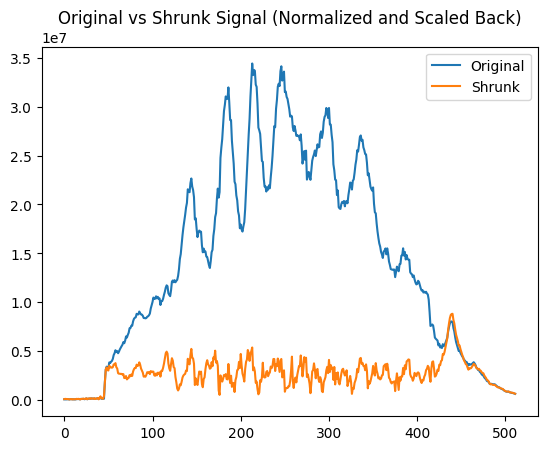

Test Segment Min/Max (Magnitude): 8624.591499060483 34446974.59536673
Normalized Test Segment Min/Max (Magnitude): 0.0002503729747058985 1.0
Shrunk Signal Min/Max (Magnitude): 5960.38302553444 8789859.660885392
YSig_normalized min/max (Magnitude): 0.00017303066802087572 0.2551707302059458


In [27]:
def mst_abs(Ssig, coarsest=3, finestlev=4):  # Further reduce finestlev to 4 to minimize boundary effects
    """
    Adaptive-Bayesian Shrinkage for one segment of complex IQ data.
    Ssig: Input complex segment (normalized to reasonable range)
    """
    # Separate real and imaginary parts
    real_part = Ssig.real
    imag_part = Ssig.imag
    
    # Step 2.1: Forward Wavelet Transform for real and imaginary parts
    wavelet = 'db8'  # Keep Daubechies 8 for better signal representation
    coeffs_real = pywt.wavedec(real_part, wavelet, level=finestlev, mode='periodization')
    coeffs_imag = pywt.wavedec(imag_part, wavelet, level=finestlev, mode='periodization')
    
    # Flatten coefficients for real and imaginary parts
    datawd_real, coeff_slices = pywt.coeffs_to_array(coeffs_real)
    datawd_imag, _ = pywt.coeffs_to_array(coeffs_imag)  # Reuse coeff_slices
    
    # Print initial coefficient stats
    print("datawd_real min/max:", datawd_real.min(), datawd_real.max())
    print("datawd_imag min/max:", datawd_imag.min(), datawd_imag.max())
    
    # Step 2.2: Compute prior parameters (combine real and imaginary for statistics)
    # Use magnitude for robustness
    datawd_mag = np.sqrt(datawd_real**2 + datawd_imag**2)
    niz = datawd_mag[2**finestlev:2**(finestlev+1)]
    nizo = np.sort(np.abs(niz))
    mm = len(nizo)
    Q1 = nizo[int(mm/4)] if mm > 0 else 0
    Q3 = nizo[int(3*mm/4)] if mm > 0 else 0
    Pseudos = max(abs(Q1 - Q3) / 1.5, 1e-2)  # Increase minimum Pseudos to 1e-2 for stability
    mu = min(1 / Pseudos**2 if Pseudos != 0 else 1e-1, 5.0)  # Reduce mu to 5.0 to prevent underflow
    
    # Scale of spread (τ) based on input signal magnitude
    sigma_d2 = np.var(np.abs(Ssig))
    tau = max(np.sqrt(max(sigma_d2 - (1/mu), 1e-6)), 0.5)  # Increase tau to 0.5 for stability
    
    print("mu:", mu)
    print("tau:", tau)
    print("Pseudos:", Pseudos)
    print("sigma_d2:", sigma_d2)
    
    # Step 2.3: Iterative shrinkage across levels (for both real and imaginary)
    for i in range(finestlev, coarsest-1, -1):
        # Weight of point mass (ϵ)
        epsilon = min(1 - (1 / (i - coarsest + 1)**1.0), 0.3)  # Keep epsilon cap at 0.3 for more shrinkage
        
        # Real part
        d_real = datawd_real[2**i:2**(i+1)] if i < finestlev else datawd_real[2**i:]
        if len(d_real) == 0:
            continue
        
        # Imaginary part
        d_imag = datawd_imag[2**i:2**(i+1)] if i < finestlev else datawd_imag[2**i:]
        
        # Compute densities and shrinkage (using magnitude for stability)
        d_mag = np.maximum(np.sqrt(d_real**2 + d_imag**2), 1e-10)  # Ensure non-negative with small epsilon
        print(f"Level {i} - d_mag min/max:", d_mag.min(), d_mag.max())
        
        de = 0.5 * np.sqrt(2*mu) * np.exp(-np.sqrt(2*mu) * d_mag)
        print(f"Level {i} - de min/max:", de.min(), de.max())
        
        m = (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-np.sqrt(2*mu)*d_mag)) / (2*tau**2 - (1/mu))
        m = np.maximum(m, 1e-10)  # Ensure non-negative with small epsilon
        print(f"Level {i} - m min/max:", m.min(), m.max())
        
        m_star = epsilon * de + (1 - epsilon) * m
        print(f"Level {i} - m_star min/max:", m_star.min(), m_star.max())
        
        # Bayes rule shrinkage (apply to real and imaginary proportionally, with clipping)
        delta_mag = (tau * (tau**2 - 1/(2*mu)) * d_mag * np.exp(-d_mag/tau) + 
                     tau**2 * (np.exp(-d_mag*np.sqrt(2*mu)) - np.exp(-d_mag/tau))) / mu
        delta_mag = np.maximum(delta_mag, 0)  # Ensure non-negative
        print(f"Level {i} - delta_mag before division min/max:", delta_mag.min(), delta_mag.max())
        
        delta_mag /= ((tau**2 - 1/(2*mu)) * (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-d_mag*np.sqrt(2*mu))) + 1e-10)  # Add small epsilon
        delta_mag = np.clip(delta_mag, 0, 0.3)  # Limit delta_mag to 0.3 to prevent over-shrinkage
        print(f"Level {i} - delta_mag min/max:", delta_mag.min(), delta_mag.max())
        
        delta_star = ((1 - epsilon) * m * delta_mag) / (m_star + 1e-10)  # Add small epsilon
        delta_star = np.clip(delta_star, 0, 0.3)  # Limit delta_star to 0.3 for controlled shrinkage
        print(f"Level {i} - delta_star min/max:", delta_star.min(), delta_star.max())
        
        # Update real and imaginary parts (scale by original magnitude direction)
        if len(d_real) > 0:
            direction = d_real + 1j * d_imag
            direction_mag = np.abs(direction)
            direction_normalized = direction / (direction_mag + 1e-10)  # Avoid division by zero
            delta_real = delta_star * direction_normalized.real
            delta_imag = delta_star * direction_normalized.imag
            
            if i < finestlev:
                datawd_real[2**i:2**(i+1)] = delta_real
                datawd_imag[2**i:2**(i+1)] = delta_imag
            else:
                datawd_real[2**i:] = delta_real
                datawd_imag[2**i:] = delta_imag
    
    # Step 2.4: Inverse Wavelet Transform for real and imaginary parts
    coeffs_updated_real = pywt.array_to_coeffs(datawd_real, coeff_slices, output_format='wavedec')
    coeffs_updated_imag = pywt.array_to_coeffs(datawd_imag, coeff_slices, output_format='wavedec')
    YSig_real = pywt.waverec(coeffs_updated_real, wavelet, mode='periodization')
    YSig_imag = pywt.waverec(coeffs_updated_imag, wavelet, mode='periodization')
    
    # Combine real and imaginary parts
    YSig = YSig_real + 1j * YSig_imag
    
    return YSig[:len(Ssig)]  # Ensure output matches input length

# Test on one segment with normalization
test_segment = segmented_data[0, 0, :]
max_magnitude = np.abs(test_segment).max()
test_segment_normalized = test_segment / (max_magnitude + 1e-10)  # Normalize to max magnitude of 1

YSig_normalized = mst_abs(test_segment_normalized)
YSig_scaled = YSig_normalized * max_magnitude  # Scale back to original magnitude range

plt.plot(np.abs(test_segment), label='Original')
plt.plot(np.abs(YSig_scaled), label='Shrunk')
plt.legend()
plt.title('Original vs Shrunk Signal (Normalized and Scaled Back)')
plt.show()

# Debug prints for input and output
print("Test Segment Min/Max (Magnitude):", np.abs(test_segment).min(), np.abs(test_segment).max())
print("Normalized Test Segment Min/Max (Magnitude):", np.abs(test_segment_normalized).min(), np.abs(test_segment_normalized).max())
print("Shrunk Signal Min/Max (Magnitude):", np.abs(YSig_scaled).min(), np.abs(YSig_scaled).max())
print("YSig_normalized min/max (Magnitude):", np.abs(YSig_normalized).min(), np.abs(YSig_normalized).max())

datawd_real min/max: -0.6642138190410278 2.8269368165598014
datawd_imag min/max: -0.4241097282994351 2.5995216056712427
mu: 0.47293572081188806
tau: 0.4
Pseudos: 1.454115625445602
sigma_d2: 0.08416023297284166
Level 4 - d_mag min/max: 5.4154807236807194e-05 3.062092041118331
Level 4 - de min/max: 0.024747338184924455 0.48625400027265125
Level 4 - m min/max: 0.02905490550098281 0.35008734079398846
Level 4 - m_star min/max: 0.027762635306165302 0.3909373386375873
Level 4 - delta_mag before division min/max: 0.0 0.04409128047188162
Level 4 - delta_mag min/max: 0.0 0.2
Level 4 - delta_star min/max: 0.0 0.14651659363845096
Level 3 - d_mag min/max: 1.6154062746055282 3.5988408793689035
Level 3 - de min/max: 0.014683110714082827 0.10105910257381667
Level 3 - m min/max: 0.017273922616127892 0.11515224325374677
Level 3 - m_star min/max: 0.017273922616127892 0.11515224325374677
Level 3 - delta_mag before division min/max: 0.009835387617337474 0.042742003933876956
Level 3 - delta_mag min/max: 0.2

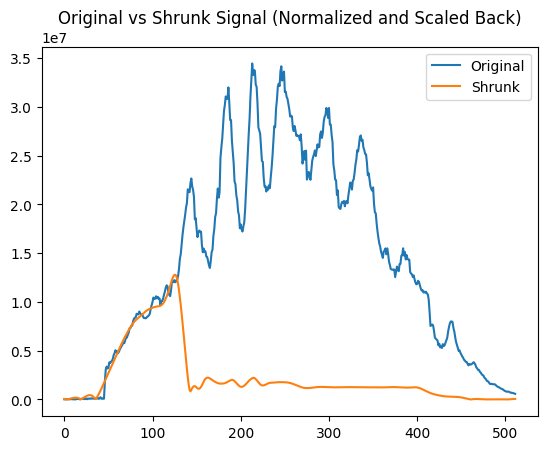

Test Segment Min/Max (Magnitude): 8624.591499060483 34446974.59536673
Normalized Test Segment Min/Max (Magnitude): 0.0002503729747058985 1.0
Shrunk Signal Min/Max (Magnitude): 1572.3836700467953 12781831.992383473
YSig_normalized min/max (Magnitude): 4.564649547650805e-05 0.37105818849190564
max_magnitude: 34446974.59536673
YSig_scaled before plotting min/max: 1572.3836700467953 12781831.992383473


In [28]:
def mst_abs(Ssig, coarsest=3, finestlev=4):  # Further reduce finestlev to 4 to minimize boundary effects
    """
    Adaptive-Bayesian Shrinkage for one segment of complex IQ data.
    Ssig: Input complex segment (normalized to reasonable range)
    """
    # Separate real and imaginary parts
    real_part = Ssig.real
    imag_part = Ssig.imag
    
    # Step 2.1: Forward Wavelet Transform for real and imaginary parts
    # wavelet = 'db8'  # Keep Daubechies 8 for better signal representation
    wavelet = 'sym8'  # Try Symlet 8
    coeffs_real = pywt.wavedec(real_part, wavelet, level=finestlev, mode='periodization')
    coeffs_imag = pywt.wavedec(imag_part, wavelet, level=finestlev, mode='periodization')
    
    # Flatten coefficients for real and imaginary parts
    datawd_real, coeff_slices = pywt.coeffs_to_array(coeffs_real)
    datawd_imag, _ = pywt.coeffs_to_array(coeffs_imag)  # Reuse coeff_slices
    
    # Print initial coefficient stats
    print("datawd_real min/max:", datawd_real.min(), datawd_real.max())
    print("datawd_imag min/max:", datawd_imag.min(), datawd_imag.max())
    
    # Step 2.2: Compute prior parameters (combine real and imaginary for statistics)
    # Use magnitude for robustness
    datawd_mag = np.sqrt(datawd_real**2 + datawd_imag**2)
    niz = datawd_mag[2**finestlev:2**(finestlev+1)]
    nizo = np.sort(np.abs(niz))
    mm = len(nizo)
    Q1 = nizo[int(mm/4)] if mm > 0 else 0
    Q3 = nizo[int(3*mm/4)] if mm > 0 else 0
    Pseudos = max(abs(Q1 - Q3) / 1.5, 1e-2)  # Increase minimum Pseudos to 1e-2 for stability
    # mu = min(1 / Pseudos**2 if Pseudos != 0 else 1e-1, 5.0)  # Reduce mu to 5.0 to prevent underflow
    mu = min(1 / Pseudos**2 if Pseudos != 0 else 1e-1, 2.0)  # Increase mu to 2.0
    
    # Scale of spread (τ) based on input signal magnitude
    sigma_d2 = np.var(np.abs(Ssig))
    # tau = max(np.sqrt(max(sigma_d2 - (1/mu), 1e-6)), 0.5)  # Increase tau to 0.5 for stability
    tau = max(np.sqrt(max(sigma_d2 - (1/mu), 1e-6)), 0.4)  # Decrease tau to 0.4
    
    print("mu:", mu)
    print("tau:", tau)
    print("Pseudos:", Pseudos)
    print("sigma_d2:", sigma_d2)
    
    # Step 2.3: Iterative shrinkage across levels (for both real and imaginary)
    for i in range(finestlev, coarsest-1, -1):
        # Weight of point mass (ϵ)
        epsilon = min(1 - (1 / (i - coarsest + 1)**1.0), 0.3)  # Keep epsilon cap at 0.3 for more shrinkage
        
        # Real part
        d_real = datawd_real[2**i:2**(i+1)] if i < finestlev else datawd_real[2**i:]
        if len(d_real) == 0:
            continue
        
        # Imaginary part
        d_imag = datawd_imag[2**i:2**(i+1)] if i < finestlev else datawd_imag[2**i:]
        
        # Compute densities and shrinkage (using magnitude for stability)
        d_mag = np.maximum(np.sqrt(d_real**2 + d_imag**2), 1e-10)  # Ensure non-negative with small epsilon
        print(f"Level {i} - d_mag min/max:", d_mag.min(), d_mag.max())
        
        de = 0.5 * np.sqrt(2*mu) * np.exp(-np.sqrt(2*mu) * d_mag)
        print(f"Level {i} - de min/max:", de.min(), de.max())
        
        m = (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-np.sqrt(2*mu)*d_mag)) / (2*tau**2 - (1/mu))
        m = np.maximum(m, 1e-10)  # Ensure non-negative with small epsilon
        print(f"Level {i} - m min/max:", m.min(), m.max())
        
        m_star = epsilon * de + (1 - epsilon) * m
        print(f"Level {i} - m_star min/max:", m_star.min(), m_star.max())
        
        # Bayes rule shrinkage (apply to real and imaginary proportionally, with clipping)
        delta_mag = (tau * (tau**2 - 1/(2*mu)) * d_mag * np.exp(-d_mag/tau) + 
                     tau**2 * (np.exp(-d_mag*np.sqrt(2*mu)) - np.exp(-d_mag/tau))) / mu
        delta_mag = np.maximum(delta_mag, 0)  # Ensure non-negative
        print(f"Level {i} - delta_mag before division min/max:", delta_mag.min(), delta_mag.max())
        
        delta_mag /= ((tau**2 - 1/(2*mu)) * (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-d_mag*np.sqrt(2*mu))) + 1e-10)  # Add small epsilon
        # delta_mag = np.clip(delta_mag, 0, 0.3)  # Limit delta_mag to 0.3 to prevent over-shrinkage
        delta_mag = np.clip(delta_mag, 0, 0.2)  # Limit delta_mag to 0.2
        print(f"Level {i} - delta_mag min/max:", delta_mag.min(), delta_mag.max())
        
        delta_star = ((1 - epsilon) * m * delta_mag) / (m_star + 1e-10)  # Add small epsilon
        # delta_star = np.clip(delta_star, 0, 0.3)  # Limit delta_star to 0.3 for controlled shrinkage
        delta_star = np.clip(delta_star, 0, 0.2)  # Limit delta_star to 0.2
        print(f"Level {i} - delta_star min/max:", delta_star.min(), delta_star.max())
        
        # Update real and imaginary parts (scale by original magnitude direction)
        if len(d_real) > 0:
            direction = d_real + 1j * d_imag
            direction_mag = np.abs(direction)
            direction_normalized = direction / (direction_mag + 1e-10)  # Avoid division by zero
            delta_real = delta_star * direction_normalized.real
            delta_imag = delta_star * direction_normalized.imag
            
            if i < finestlev:
                datawd_real[2**i:2**(i+1)] = delta_real
                datawd_imag[2**i:2**(i+1)] = delta_imag
            else:
                datawd_real[2**i:] = delta_real
                datawd_imag[2**i:] = delta_imag
    
    # Step 2.4: Inverse Wavelet Transform for real and imaginary parts
    coeffs_updated_real = pywt.array_to_coeffs(datawd_real, coeff_slices, output_format='wavedec')
    coeffs_updated_imag = pywt.array_to_coeffs(datawd_imag, coeff_slices, output_format='wavedec')
    YSig_real = pywt.waverec(coeffs_updated_real, wavelet, mode='periodization')
    YSig_imag = pywt.waverec(coeffs_updated_imag, wavelet, mode='periodization')
    
    # Combine real and imaginary parts
    YSig = YSig_real + 1j * YSig_imag
    
    return YSig[:len(Ssig)]  # Ensure output matches input length

# Test on one segment with normalization
test_segment = segmented_data[0, 0, :]
max_magnitude = np.abs(test_segment).max()
test_segment_normalized = test_segment / (max_magnitude + 1e-10)  # Normalize to max magnitude of 1

YSig_normalized = mst_abs(test_segment_normalized)
YSig_scaled = YSig_normalized * max_magnitude  # Scale back to original magnitude range

plt.plot(np.abs(test_segment), label='Original')
plt.plot(np.abs(YSig_scaled), label='Shrunk')
plt.legend()
plt.title('Original vs Shrunk Signal (Normalized and Scaled Back)')
plt.show()

# Debug prints for input and output
print("Test Segment Min/Max (Magnitude):", np.abs(test_segment).min(), np.abs(test_segment).max())
print("Normalized Test Segment Min/Max (Magnitude):", np.abs(test_segment_normalized).min(), np.abs(test_segment_normalized).max())
print("Shrunk Signal Min/Max (Magnitude):", np.abs(YSig_scaled).min(), np.abs(YSig_scaled).max())
print("YSig_normalized min/max (Magnitude):", np.abs(YSig_normalized).min(), np.abs(YSig_normalized).max())
print("max_magnitude:", max_magnitude)
print("YSig_scaled before plotting min/max:", np.abs(YSig_scaled).min(), np.abs(YSig_scaled).max())